# Reionised bubbles around primordial galaxies

## Introduction

This is the second ipython notebook to be followed alongside the exercise sheet. Again, the following code only serves as a starting point, feel free to adjust it as you see fit.

In addition to these required 'standard' packages (discussed in the first notebook), we will use some custom, pre-written code from a module called [`lymana_absorption`](https://github.com/joriswitstok/lymana_absorption). First, you'll need to obtain the source code with `git` in an installation directory of choice:
```
git clone https://github.com/joriswitstok/lymana_absorption.git
```
Then, you can follow the repository's instructions to install the code into your Anaconda environment (double checking if it is still activated):
```
cd lymana_absorption
which pip3
~/anaconda3/envs/bubble3/bin/pip3 install .
```

In [1]:
# Load necessary packages
import os

import numpy as np
import math

import lmfit
from spectres import spectres

import matplotlib
%matplotlib inline
print("Matplotlib", matplotlib.__version__, "(backend: " + matplotlib.get_backend() + ')')
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("ticks")

# Load matplotlib style file
plt.style.use("../auxiliary/bubble.mplstyle")
def_linewidth = plt.rcParams["lines.linewidth"]
def_markersize = plt.rcParams["lines.markersize"]

pformat = ".png"
dpi = 300

# Import astropy cosmology, given H0 and Omega_matter (Planck Collaboration 2020)
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.315, Ob0=0.02237/0.674**2, Tcmb0=2.726)

from astropy.io import fits
from astroquery.mast import Observations

Matplotlib 3.10.0 (backend: inline)


## Gather spectroscopic data and measure the redshift and line fluxes

First, we will define a function to download the data from MAST using `astroquery`.

In [2]:
def download_data(obs_id, force_download=False):
    if force_download or not os.path.isfile("../data/mastDownload/HLSP/{obs_id}/{obs_id}_x1d.fits".format(obs_id=obs_id)):
        obs_table = Observations.query_criteria(provenance_name="JADES", instrument_name="NIRSPEC", obs_id=obs_id)
        data_products = Observations.get_product_list(obs_table)
        Observations.download_products(data_products, download_dir="../data/")
    else:
        print("Data products already downloaded.")

filter_gratings = ["clear-prism", "f070lp-g140m", "f290lp-g395m"]

Next, we define a function to plot the spectra.

In [3]:
# Lyα wavelength
wl_Lya = 1215.67 # Angstrom
# Convenient scaling factor for flux densities
conv = 1e20

colors1 = sns.color_palette("Set1", 9)

def plot_spectra(ID, wl_obs_dict, flux_dict, flux_err_dict, redshift=None, savefig=False):
    fig = plt.figure(figsize=(8.27, 8.27/2))
    gs = fig.add_gridspec(nrows=2, ncols=2, hspace=0.2, wspace=0.2, width_ratios=[1, 2])
    axes = {}

    # Create an (invisible) label axes spanning all subplots
    axes["label"] = fig.add_subplot(gs[:, :])
    ax_r = axes["label"].secondary_xaxis("top")
    for ax in [axes["label"], ax_r]:
        ax.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        for spine in ax.spines.values():
            spine.set_visible(False)

    axes["label"].set_xlabel(r"Observed wavelength $\lambda_\mathrm{obs} \, (\mathrm{\mu m})$", labelpad=20)
    axes["label"].set_ylabel(r"Flux density $F_\lambda \, (10^{{{:d}}} \, \mathrm{{erg \, s^{{-1}} \, cm^{{-2}} \, \AA^{{-1}}}})$".format(int(-np.log10(conv))), labelpad=25)

    axes["label"].annotate(text="ID {}".format(ID), xy=(0.5, 1), xytext=(0, 8),
                            xycoords="axes fraction", textcoords="offset points", va="top", ha="center")

    # Create different axes for each disperser
    for fg, c in zip(filter_gratings, colors1):
        rowi = 0 if fg == "clear-prism" else 1
        coli = slice(None) if fg == "clear-prism" else list(filter_gratings).index(fg)-1
        
        axes[fg] = fig.add_subplot(gs[rowi, coli])

        axes[fg].axhline(y=0, color='k', alpha=0.8)
        axes[fg].annotate(text=fg, xy=(1, 1), xytext=(-8, -8), xycoords="axes fraction", textcoords="offset points",
                            va="top", ha="right", color=c)

        wl_obs = wl_obs_dict[fg]
        flux = flux_dict[fg]
        flux_err = flux_err_dict[fg]
        
        if redshift is not None:
            obs_wl_Lya = wl_Lya / 1e4 * (1.0+redshift)
            if obs_wl_Lya > np.min(wl_obs) and obs_wl_Lya < np.max(wl_obs):
                axes[fg].axvline(obs_wl_Lya, 0, 0.9, linestyle='--', color='k', alpha=0.8)
                axes[fg].annotate(text="Lyα", xy=(obs_wl_Lya, 1), xytext=(0, -4),
                                xycoords=axes[fg].get_xaxis_transform(), textcoords="offset points",
                                va="top", ha="center", size="small")
        
        axes[fg].plot(wl_obs, flux*conv, drawstyle="steps-mid", color=c, alpha=0.8, zorder=1)
        axes[fg].fill_between(wl_obs, (flux-flux_err)*conv, (flux+flux_err)*conv, step="mid",
                            edgecolor="None", facecolor=c, alpha=0.2, zorder=0.5)

        if redshift is not None and fg == "f070lp-g140m":
            axes[fg].set_xlim(0.98*obs_wl_Lya, 1.02*obs_wl_Lya)
        else:
            axes[fg].set_xlim(np.min(wl_obs), np.max(wl_obs))
        axes[fg].set_ylim(1.25*np.nanmin(flux[wl_obs > 1.0]*conv), 1.25*np.nanmax(flux[wl_obs > 1.0]*conv))

    if savefig:
        fig.savefig("../plots/spectra_{}".format(ID) + pformat, dpi=dpi, bbox_inches="tight")
    
    return (fig, axes)

## Measure redshift and line fluxes for ID 1899 in GOODS-N

First, load in the data and plot the spectra.

Data products already downloaded.
Done!
Reading in clear-prism spectrum of ID 1899 in goods-n... Done!
Data products already downloaded.
Done!
Reading in f070lp-g140m spectrum of ID 1899 in goods-n... Done!
Data products already downloaded.
Done!
Reading in f290lp-g395m spectrum of ID 1899 in goods-n... Done!


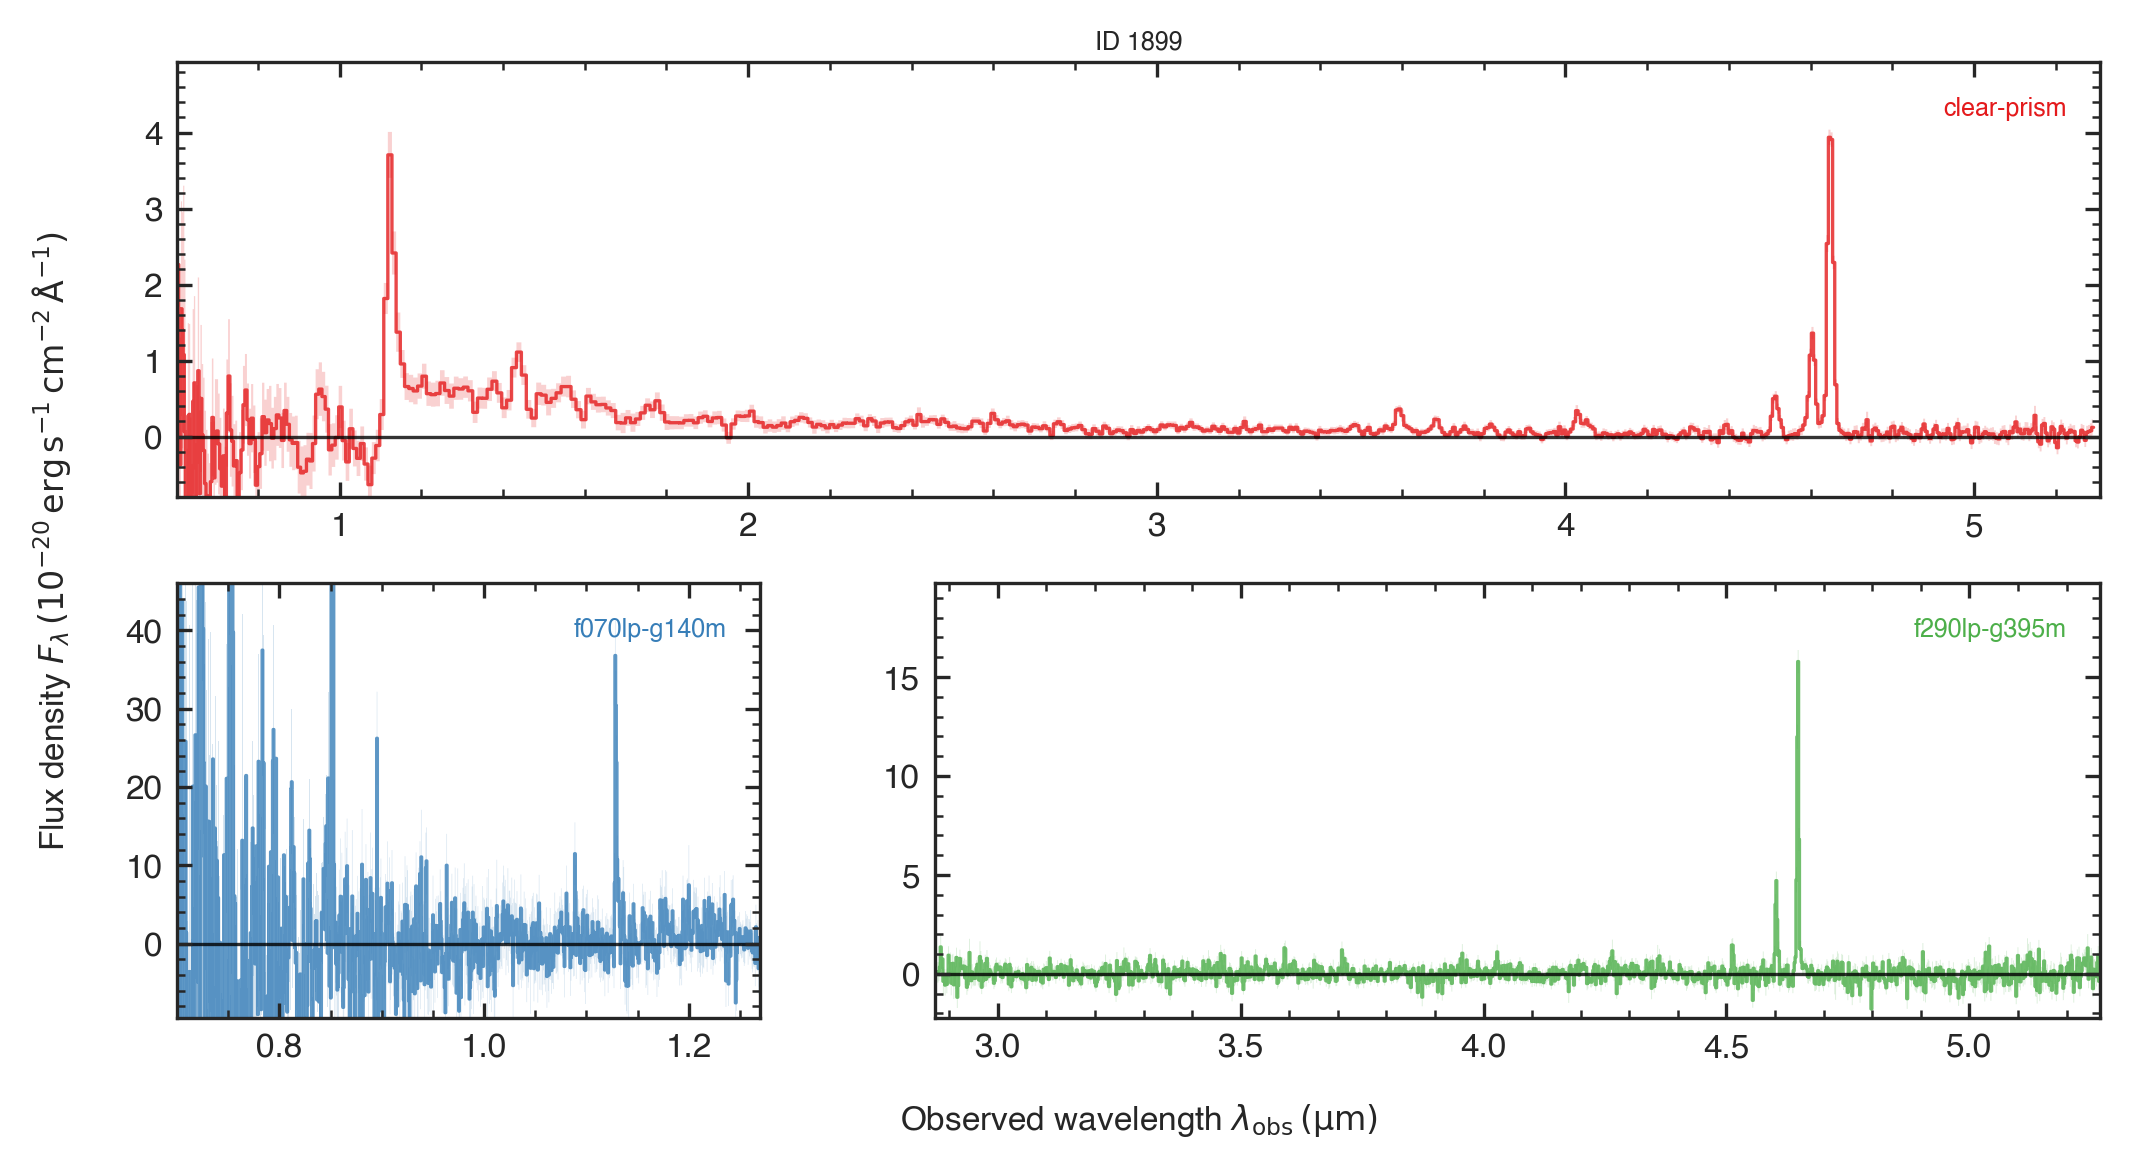

In [4]:
field = "goods-n"
tier = "mediumhst"
ID = 1899

wl_obs_dict = {}
flux_dict = {}
flux_err_dict = {}

for fg in filter_gratings:
    print("Downloading {} spectrum of ID {} in {}...".format(fg, ID, field))
    obs_id = "hlsp_jades_jwst_nirspec_{}-{}-{:08d}_{}_v1.0".format(field, tier, ID, fg)
    download_data(obs_id)
    print("Done!")

    print("Reading in {} spectrum of ID {} in {}...".format(fg, ID, field), end=' ')
    with fits.open("../data/mastDownload/HLSP/{obs_id}/{obs_id}_x1d.fits".format(obs_id=obs_id)) as hdulist_1D:
        wl_obs_dict[fg] = hdulist_1D["EXTRACT1D"].data["WAVELENGTH"] # in μm
        flux_dict[fg] = hdulist_1D["EXTRACT1D"].data["FLUX"] # in erg/s/cm^2/Å
        flux_err_dict[fg] = hdulist_1D["EXTRACT1D"].data["FLUX_ERR"] # in erg/s/cm^2/Å
    print("Done!")

fig = plot_spectra(ID, wl_obs_dict, flux_dict, flux_err_dict, savefig=True)[0]
plt.show()
plt.close(fig)

Next, define a model of Gaussian emission line profiles.

In [5]:
# FWHM of the line spread function, Δλ = λ/R, is ~2.35 times the dispersion σ
FWHM_to_sigma = (2.0 * np.sqrt(2.0 * np.log(2.0)))

def Gaussian(A, x0, y0, sigma, x):
    # Gaussian profile with amplitude A, mean x0, variance sigma^2, and offset y0
    return A / (np.sqrt(2*np.pi)*sigma) * np.exp( -(x-x0)**2 / (2.0*sigma**2) ) + y0

def emission_line_model(params, x, data=None, data_err=None, line_dict={}, spectral_resolution=10000.0):
    if isinstance(params, type(lmfit.Parameters())):
        params = params.valuesdict()

    # Start by calculating the required resolution of the model wavelength grid,
    # which we want to properly sample the line spread function, requiring a
    # step size of at least 3x the dispersion (σ)
    dx_model = np.min(x) / spectral_resolution / FWHM_to_sigma / 3.0
    # Initialise high-resolution model wavelength grid
    x_model = np.arange(np.min(x)-10*dx_model, np.max(x)+10*dx_model, dx_model)
    # Initialise a model flux-density array at constant continuum level
    y_model = np.tile(float(params["cont"]), x_model.shape)

    for line, wl in line_dict.items():
        # Observed (redshifted) wavelength of the line
        wl_obs = wl * (1.0+params['z'])
        if "deltav_{}".format(line) in params:
            # If a velocity offset is specified, shift the line centre
            wl_obs /= (1.0 - params["deltav_{}".format(line)] / 299792.458)
        
        # Convert intrinsic velocity width to wavelength space
        sigma_l = wl_obs / (299792.458/params["sigma_v"] - 1.0)
        # Convolve with a Gaussian line spread function (dispersion σ adds quadratically)
        sigma_conv = np.sqrt(sigma_l**2 + (wl_obs / spectral_resolution / FWHM_to_sigma)**2)
        # Add the line to the model spectrum
        y_model += Gaussian(A=params["amplitude_{}".format(line)], x0=wl_obs, y0=0, sigma=sigma_conv, x=x_model)

    if data is None:
        # Return the high-resolution model directly
        return (x_model, y_model)
    else:
        # Rebin the high-resolution model to the observed data wavelength bins
        model = spectres(x, x_model, y_model)
        if data_err is None:
            return model - data
        else:
            return (model-data) / data_err

Set up the model to measure the redshift of ID 1899 with the rest-frame optical lines.

Redshift guess: 8.280
Expected precision: 0.00130


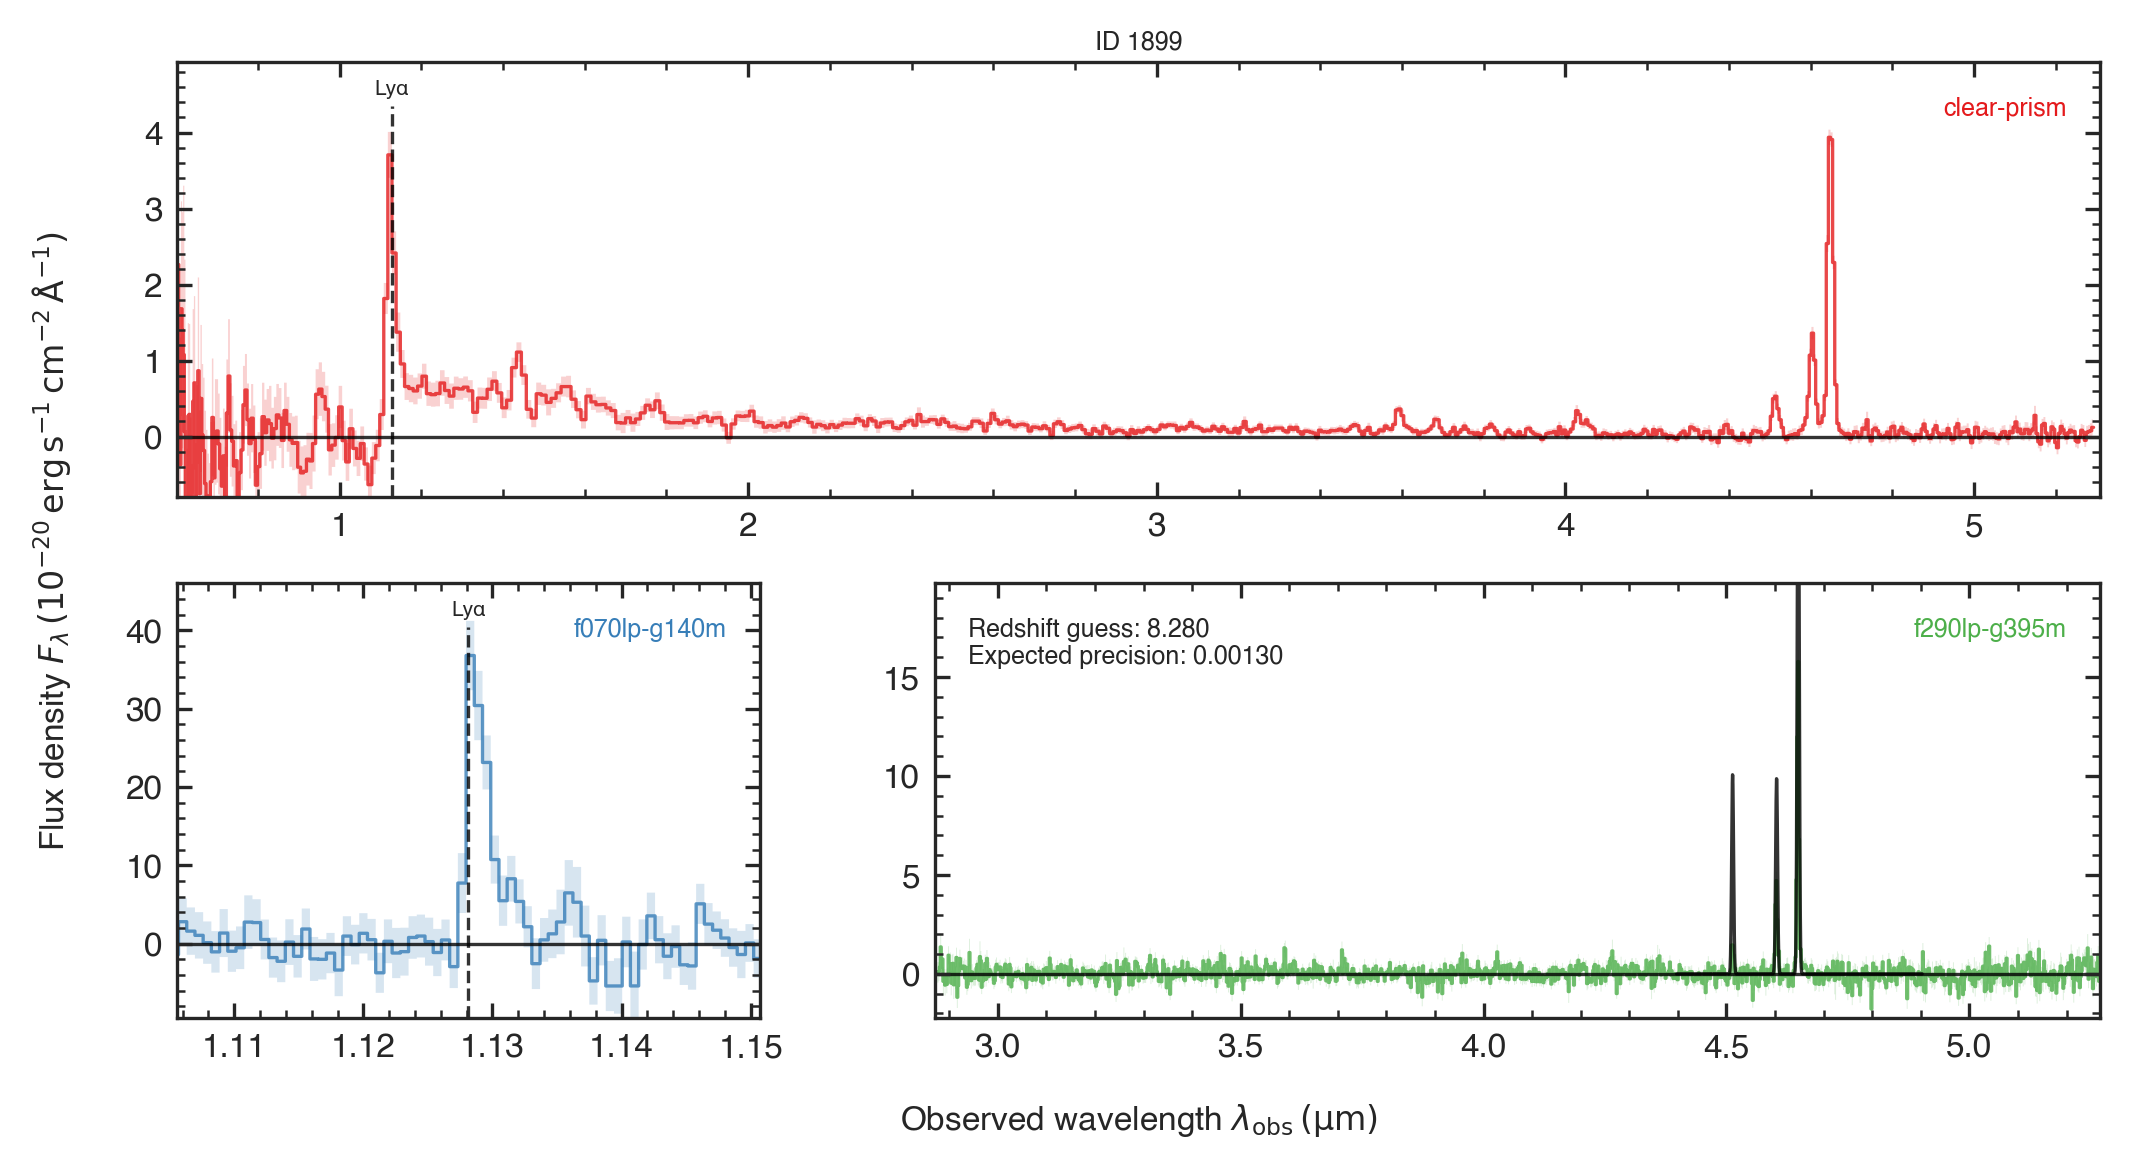

In [6]:
# Verify the currently loaded data is still for ID 1899
assert ID == 1899

# Set up parameters, starting with redshift (z), continuum level (cont), and line width in velocity space (sigma_v)
params = lmfit.Parameters()

z_guess = 8.28
z_min = 8.25
z_max = 8.32

#                NAME           VALUE           VARY        MIN     MAX         EXPR        BRUTE_STEP
params.add_many(('z',           z_guess,        True,       z_min,  z_max,      None,       None),
                ("cont",        0.0,            False,      None,   None,       None,       None),
                ("sigma_v",     100.0,          True,       0,      500,        None,       None))

# Conversion from μm to Å
lconv = 1e4

# Select finite subset of the G395M data to fit to
wl_select = (wl_obs_dict["f290lp-g395m"] > 4.4) * (wl_obs_dict["f290lp-g395m"] < 4.9)
x_fit = wl_obs_dict["f290lp-g395m"][wl_select] * lconv # from μm to Å
y_fit = flux_dict["f290lp-g395m"][wl_select] * conv # in 1e-21 erg/s/cm^2/Å
y_fit_err = flux_err_dict["f290lp-g395m"][wl_select] * conv # in 1e-21 erg/s/cm^2/Å

# Assume a constant spectral resolution of R = 1500
spectral_resolution = 1500.0

# Dictionary containing rest-frame wavelengths of lines to be fit
line_dict = {"Hbeta": 4862.71, "OIII4960": 4960.295, "OIII5008": 5008.24}

# For each line, add amplitude parameter
for line in line_dict:
    expr = "amplitude_OIII4960 * 2.98" if line == "OIII5008" else None
    params.add("amplitude_{}".format(line), value=500, vary=True, min=0, max=1e4, expr=expr)

# Plot an example model
fig, axes = plot_spectra(ID, wl_obs_dict, flux_dict, flux_err_dict, redshift=z_guess)

text = "Redshift guess: {:.3f}".format(z_guess)
text += "\nExpected precision: {:.5f}".format(line_dict["OIII4960"]/1e4*(1.0+z_guess)/spectral_resolution/FWHM_to_sigma)
print(text)
axes["f290lp-g395m"].annotate(text=text, xy=(0, 1), xytext=(8, -8),
                              xycoords="axes fraction", textcoords="offset points", va="top", ha="left")
x_model, y_model = emission_line_model(params.copy(), x=x_fit, line_dict=line_dict, spectral_resolution=spectral_resolution)
axes["f290lp-g395m"].plot(x_model/lconv, y_model, color='k', alpha=0.8)

plt.show()
plt.close(fig)

Next, fit the model.

In [7]:
# Verify the currently loaded data is still for ID 1899
assert ID == 1899

# Fit the model to the data
fit_result = lmfit.minimize(emission_line_model, params, method="leastsq",
                            args=(x_fit,), kws=dict(data=y_fit, data_err=y_fit_err,
                            line_dict=line_dict, spectral_resolution=spectral_resolution))
print(fit_result.message)
fit_result.params.pretty_print()
print(lmfit.fit_report(fit_result))

Fit succeeded.
Name                   Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude_Hbeta        74.08        0    1e+04    12.03     True     None     None
amplitude_OIII4960     247.5        0    1e+04    7.827     True     None     None
amplitude_OIII5008     737.6        0    1e+04    23.32    False amplitude_OIII4960 * 2.98     None
cont                       0     -inf      inf        0    False     None     None
sigma_v                81.04        0      500    6.219     True     None     None
z                      8.279     8.25     8.32 0.0001411     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 278
    # variables        = 4
    chi-square         = 303.662589
    reduced chi-square = 1.10825762
    Akaike info crit   = 32.5463064
    Bayesian info crit = 47.0567909
[[Variables]]
    z:                   8.27862324 +/- 1.4110e-04 (0.00%) (init = 8.28)
    cont:        

Having performed the fitting procedure, plot the results.

Measured redshift: 8.278623 ± 0.000141


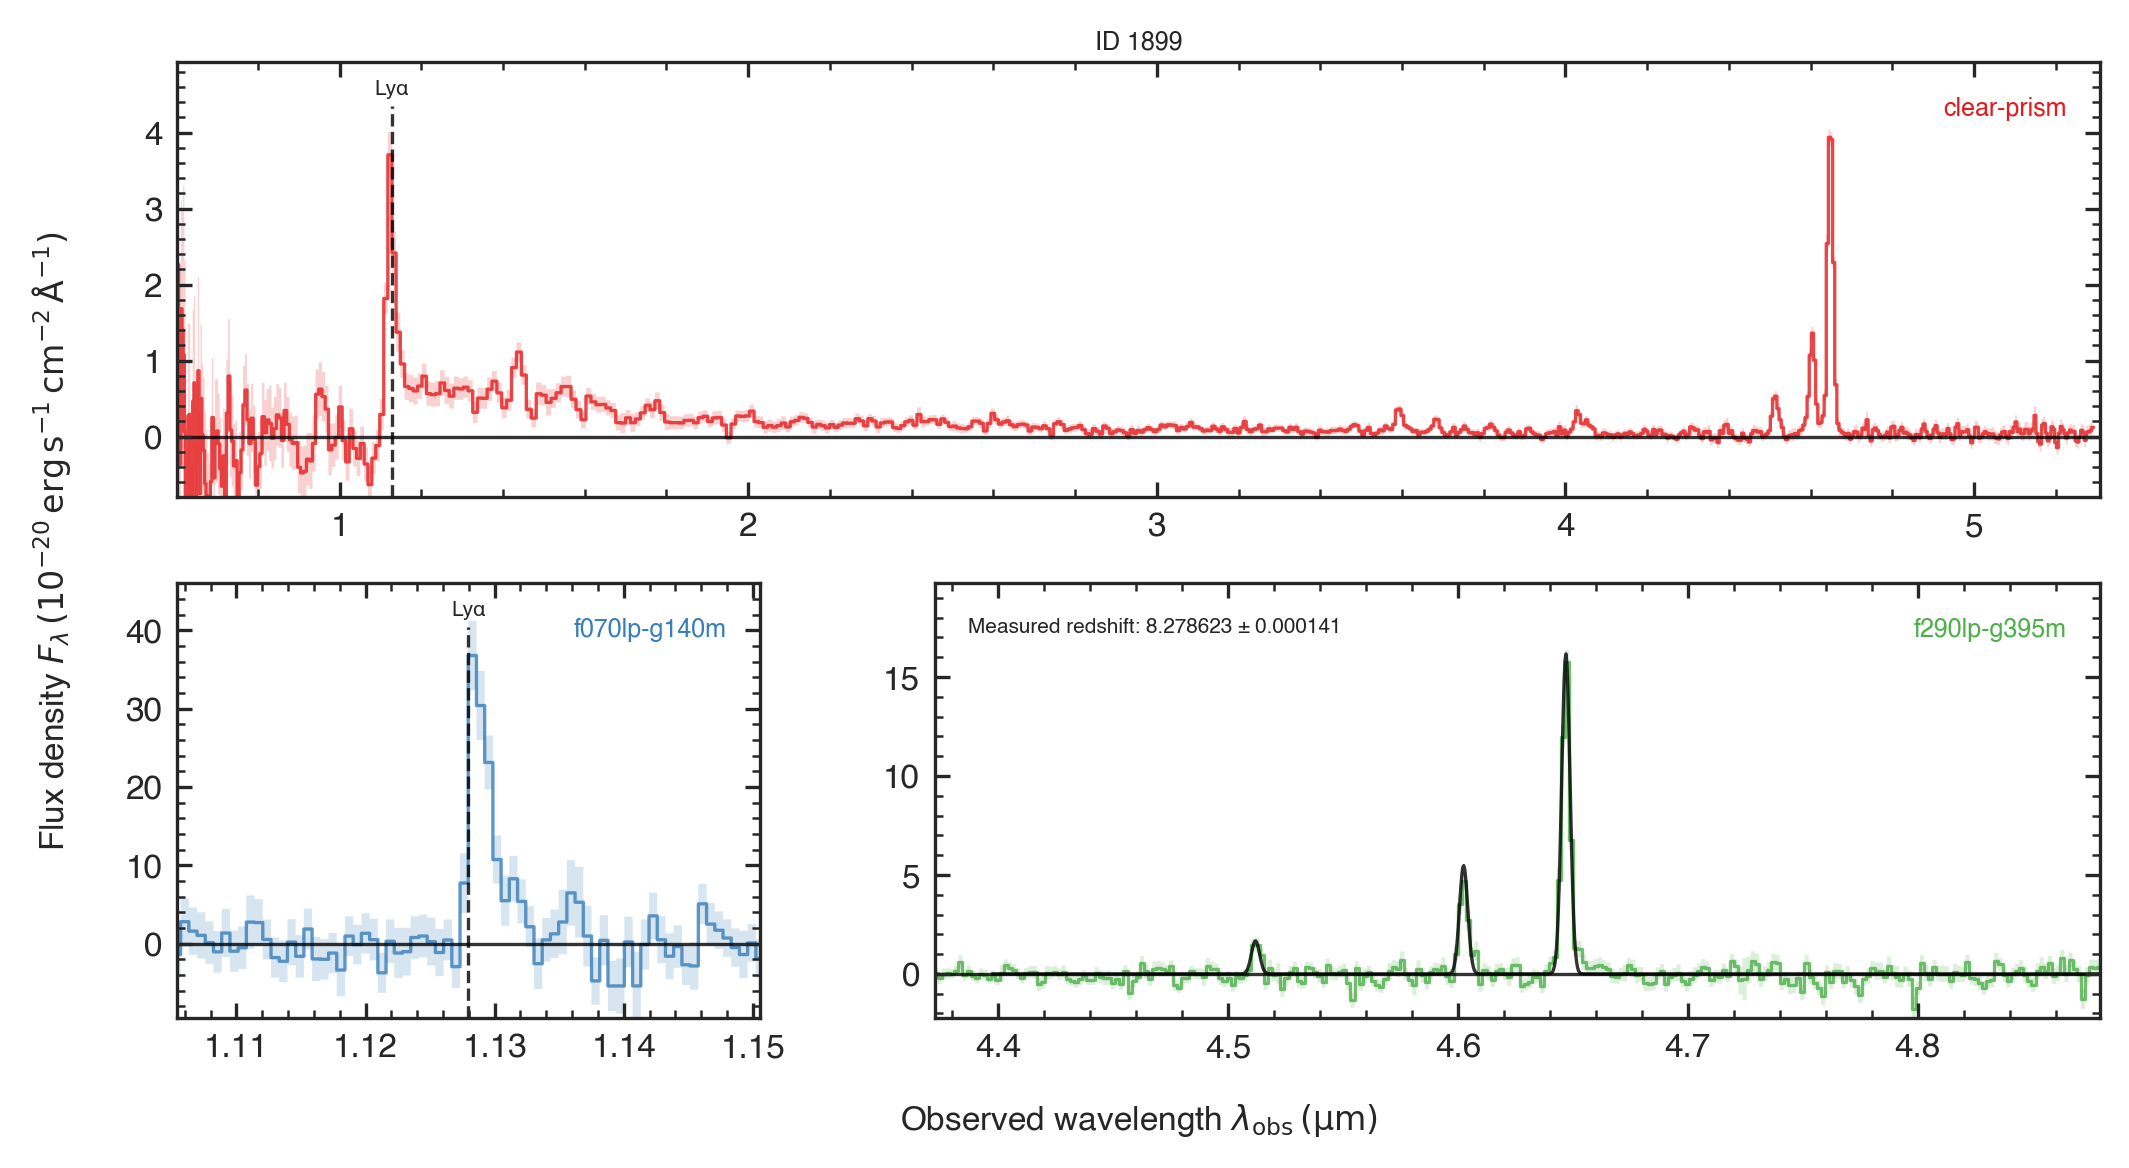

In [8]:
# Verify the currently loaded data is still for ID 1899
assert ID == 1899

# Read in the best-fit redshift and its uncertainty
fit_values = fit_result.params.valuesdict()
z_fit = fit_values['z']
z_fit_err = fit_result.params.get('z').stderr
F_Hbeta_fit = fit_values["amplitude_Hbeta"]
F_Hbeta_fit_err = fit_result.params.get("amplitude_Hbeta").stderr

# Show the best-fit high-resolution model curve
fig, axes = plot_spectra(ID, wl_obs_dict, flux_dict, flux_err_dict, redshift=z_fit)

text = "Measured redshift: {:.{prec}f} ± {:.{prec}f}".format(z_fit, z_fit_err, prec=max(0, 2-math.floor(np.log10(z_fit_err))))
print(text)
axes["f290lp-g395m"].annotate(text=text, xy=(0, 1), xytext=(8, -8), xycoords="axes fraction", textcoords="offset points",
                                va="top", ha="left", size="small")

x_model, y_model = emission_line_model(fit_values, x=x_fit, line_dict=line_dict, spectral_resolution=spectral_resolution)
axes["f290lp-g395m"].plot(x_model/lconv, y_model, color='k', alpha=0.8)

axes["f290lp-g395m"].set_xlim(0.95*line_dict["OIII4960"]*(1.0+z_fit)/lconv, 1.05*line_dict["OIII5008"]*(1.0+z_fit)/lconv)

plt.show()
plt.close(fig)

With a measured redshift, measure the flux of the Lyα line.

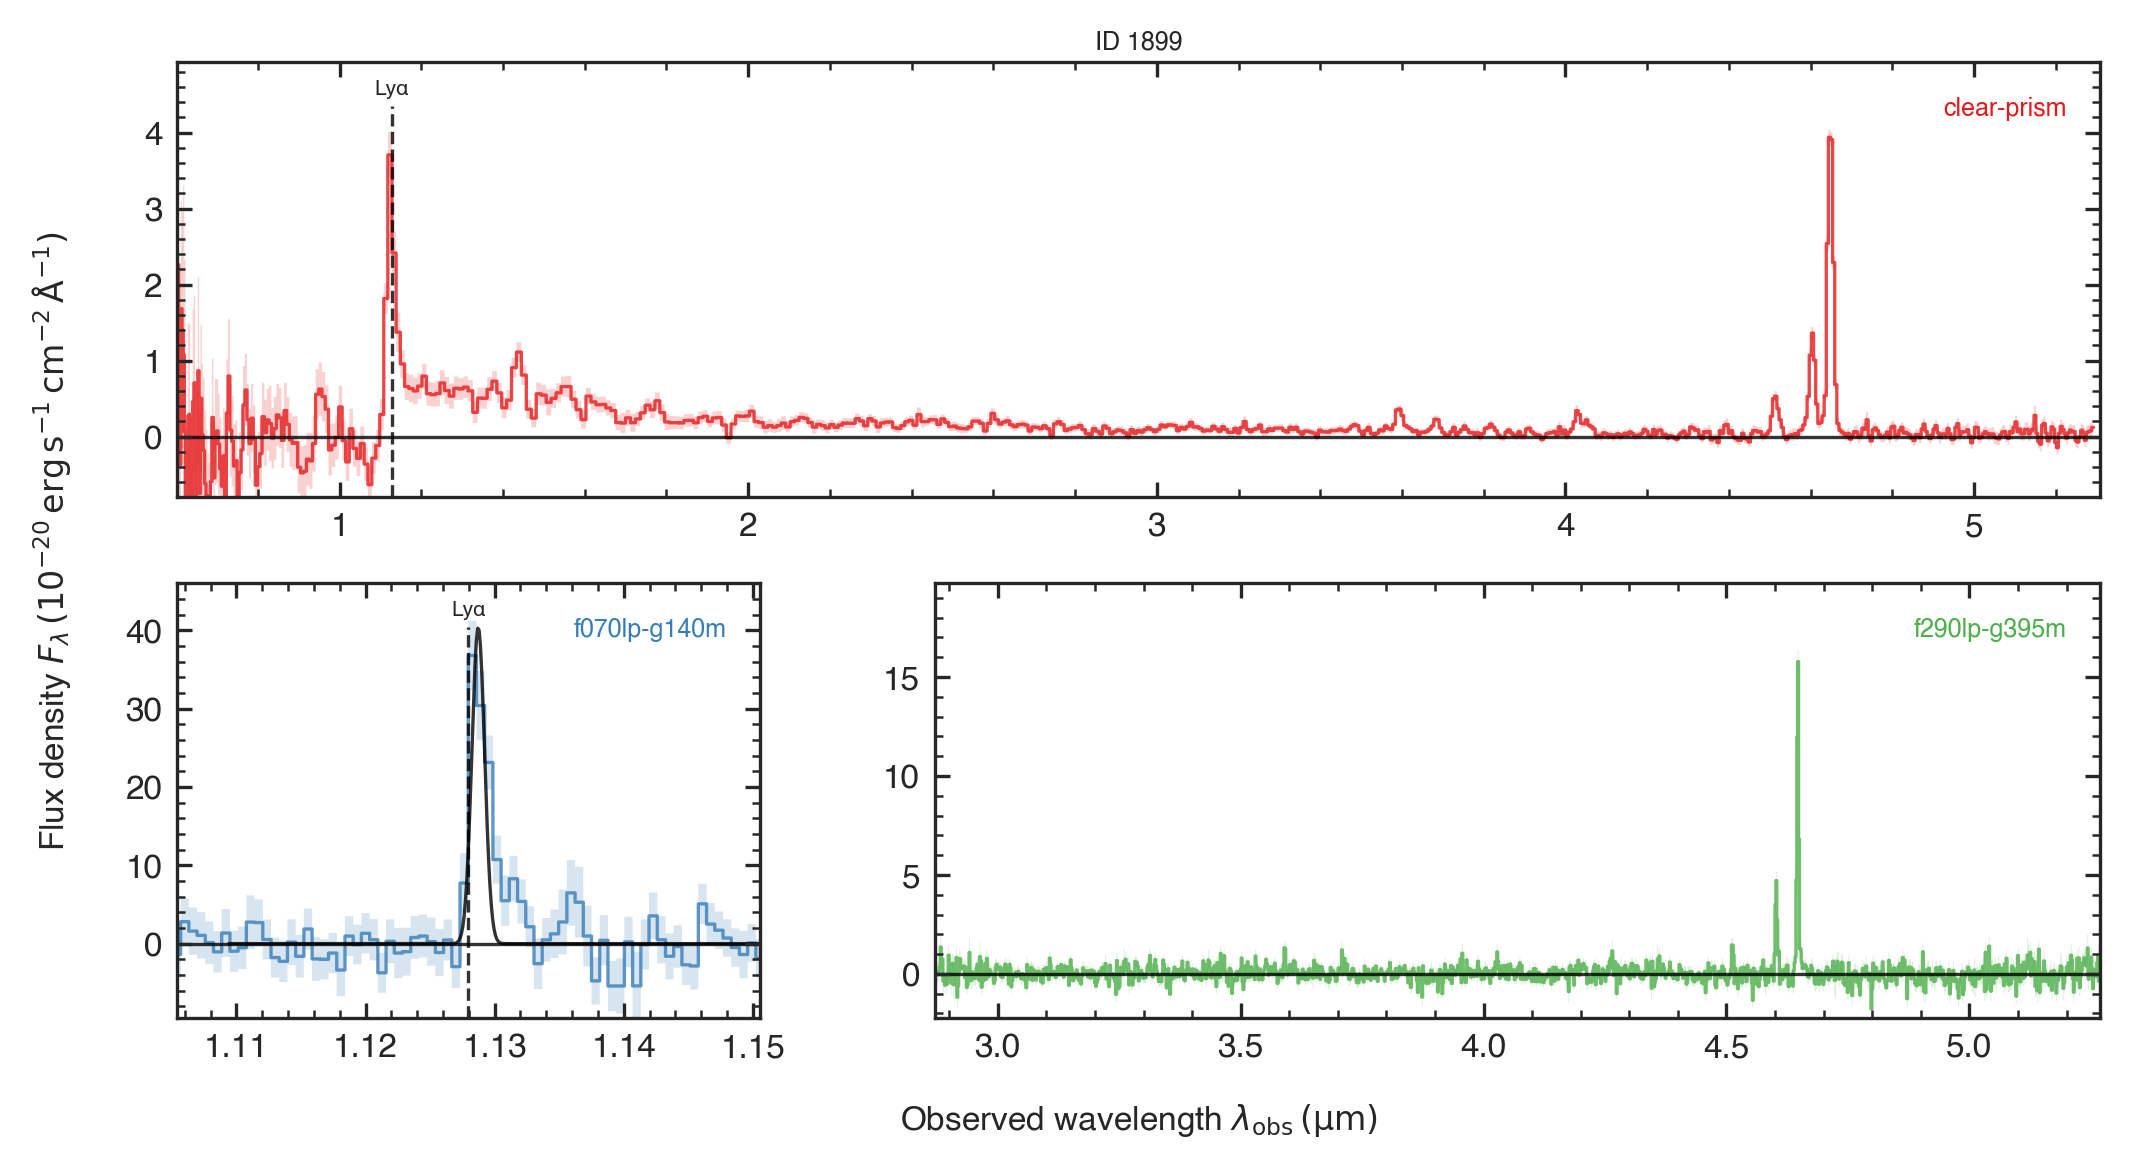

In [9]:
# Verify the currently loaded data is still for ID 1899
assert ID == 1899

# Set up parameters, starting with redshift (z), continuum level (cont), and line width in velocity space (sigma_v)
params = lmfit.Parameters()

#                NAME           VALUE           VARY        MIN     MAX         EXPR        BRUTE_STEP
params.add_many(('z',           z_fit,          False,      None,   None,       None,       None),
                ("cont",        0.0,            False,      None,   None,       None,       None),
                ("sigma_v",     100.0,          True,       0,      500,        None,       None))

# Given the lower SNR in the G395M spectrum, this time we will fit to the
# lower-resolution PRISM data – again select finite subset to fit to
wl_select = (wl_obs_dict["f070lp-g140m"] > 1.11) * (wl_obs_dict["f070lp-g140m"] < 1.15)
x_fit = wl_obs_dict["f070lp-g140m"][wl_select] * lconv # from μm to Å
y_fit = flux_dict["f070lp-g140m"][wl_select] * conv # in 1e-21 erg/s/cm^2/Å
y_fit_err = flux_err_dict["f070lp-g140m"][wl_select] * conv # in 1e-21 erg/s/cm^2/Å

# Assume a constant spectral resolution of R = 1500
spectral_resolution = 1500.0

# Dictionary containing rest-frame wavelengths of lines to be fit
line_dict = {"Lya": wl_Lya}

# Add amplitude parameter and velocity offset
for line in line_dict:
    params.add("amplitude_{}".format(line), value=500, vary=True, min=0, max=1e4)
    params.add("deltav_{}".format(line), value=200, vary=True, min=0, max=300)

# Plot an example model
fig, axes = plot_spectra(ID, wl_obs_dict, flux_dict, flux_err_dict, redshift=z_fit)

x_model, y_model = emission_line_model(params.copy(), x=x_fit, line_dict=line_dict, spectral_resolution=spectral_resolution)
axes["f070lp-g140m"].plot(x_model/lconv, y_model, color='k', alpha=0.8)

plt.show()
plt.close(fig)

Next, fit the model.

In [10]:
# Verify the currently loaded data is still for ID 10013682
assert ID == 1899

# Fit the model to the data
fit_result = lmfit.minimize(emission_line_model, params, method="leastsq",
                            args=(x_fit,), kws=dict(data=y_fit, data_err=y_fit_err,
                            line_dict=line_dict, spectral_resolution=spectral_resolution))
print(fit_result.message)
fit_result.params.pretty_print()
print(lmfit.fit_report(fit_result))

Fit succeeded.
Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude_Lya     710.9        0    1e+04    59.32     True     None     None
cont                  0     -inf      inf        0    False     None     None
deltav_Lya        234.7        0      300    20.45     True     None     None
sigma_v           188.9        0      500    21.88     True     None     None
z                 8.279     -inf      inf        0    False     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 63
    # variables        = 3
    chi-square         = 57.3000486
    reduced chi-square = 0.95500081
    Akaike info crit   = 0.02550497
    Bayesian info crit = 6.45490915
[[Variables]]
    z:              8.278623 (fixed)
    cont:           0 (fixed)
    sigma_v:        188.902947 +/- 21.8846556 (11.59%) (init = 100)
    amplitude_Lya:  710.871807 +/- 59.3171376 (8.34%) (init = 500)
    deltav_Lya:     

Having performed the fitting procedure, plot the results.

Lyα measurements
Flux: 710.9 ± 59.3 x 10^-20 erg/s/cm^2
Δv: 234.7 ± 20.4 km/s
Flux ratio with Hβ: 9.60 ± 1.75
Escape fraction: 0.41 ± 0.08


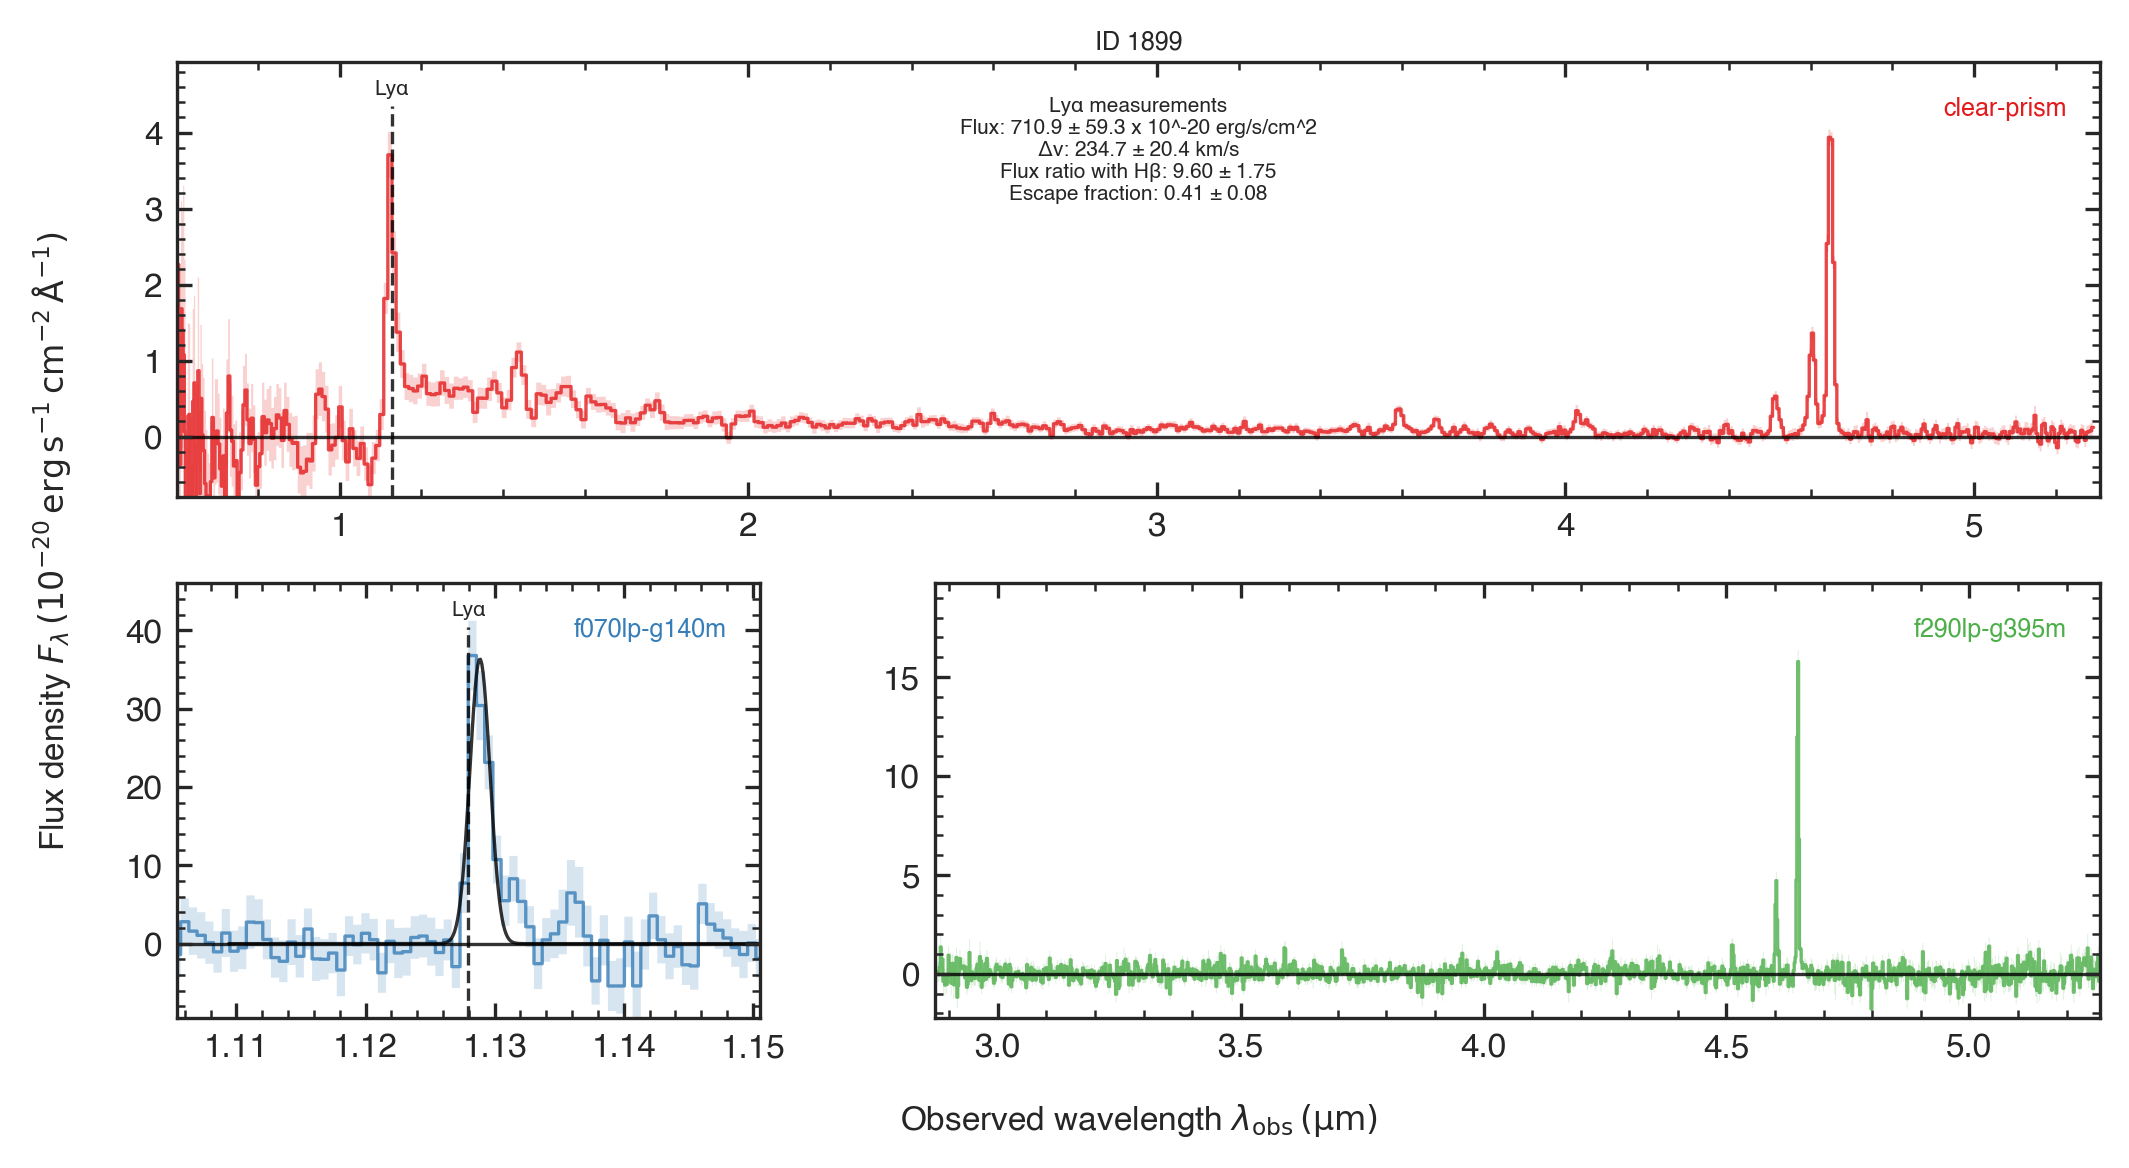

In [11]:
# Verify the currently loaded data is still for ID 1899
assert ID == 1899

# Read in the best-fit redshift and its uncertainty
fit_values = fit_result.params.valuesdict()
F_Lya_fit = fit_values["amplitude_Lya"]
F_Lya_fit_err = fit_result.params.get("amplitude_Lya").stderr
deltav_Lya_fit = fit_values["deltav_Lya"]
deltav_Lya_fit_err = fit_result.params.get("deltav_Lya").stderr

Lya_Hbeta_ratio = F_Lya_fit / F_Hbeta_fit
Lya_Hbeta_ratio_err = Lya_Hbeta_ratio * np.sqrt((F_Lya_fit_err/F_Lya_fit)**2 + (F_Hbeta_fit_err/F_Hbeta_fit)**2)
f_esc_Lya = Lya_Hbeta_ratio / 23.3
f_esc_Lya_err = Lya_Hbeta_ratio_err / 23.3

# Show the best-fit high-resolution model curve
fig, axes = plot_spectra(ID, wl_obs_dict, flux_dict, flux_err_dict, redshift=z_fit)

text = "Lyα measurements"
text += "\nFlux: {:.{prec}f} ± {:.{prec}f} x 10^-20 erg/s/cm^2".format(F_Lya_fit, F_Lya_fit_err, prec=max(0, 2-math.floor(np.log10(F_Lya_fit_err))))
text += "\nΔv: {:.{prec}f} ± {:.{prec}f} km/s".format(deltav_Lya_fit, deltav_Lya_fit_err, prec=max(0, 2-math.floor(np.log10(deltav_Lya_fit_err))))
text += "\nFlux ratio with Hβ: {:.2f} ± {:.2f}".format(Lya_Hbeta_ratio, Lya_Hbeta_ratio_err)
text += "\nEscape fraction: {:.2f} ± {:.2f}".format(f_esc_Lya, f_esc_Lya_err)
print(text)
axes["clear-prism"].annotate(text=text, xy=(0.5, 1), xytext=(0, -8), xycoords="axes fraction", textcoords="offset points",
                                va="top", ha="center", size="small")

x_model, y_model = emission_line_model(fit_values, x=x_fit, line_dict=line_dict, spectral_resolution=spectral_resolution)
axes["f070lp-g140m"].plot(x_model/lconv, y_model, color='k', alpha=0.8)

plt.show()
plt.close(fig)

## Measure redshift and line fluxes for ID 10013682 in GOODS-S

First, load in the data and plot the spectra.

Data products already downloaded.
Done!
Reading in clear-prism spectrum of ID 10013682 in goods-s... Done!
Data products already downloaded.
Done!
Reading in f070lp-g140m spectrum of ID 10013682 in goods-s... Done!
Data products already downloaded.
Done!
Reading in f290lp-g395m spectrum of ID 10013682 in goods-s... Done!


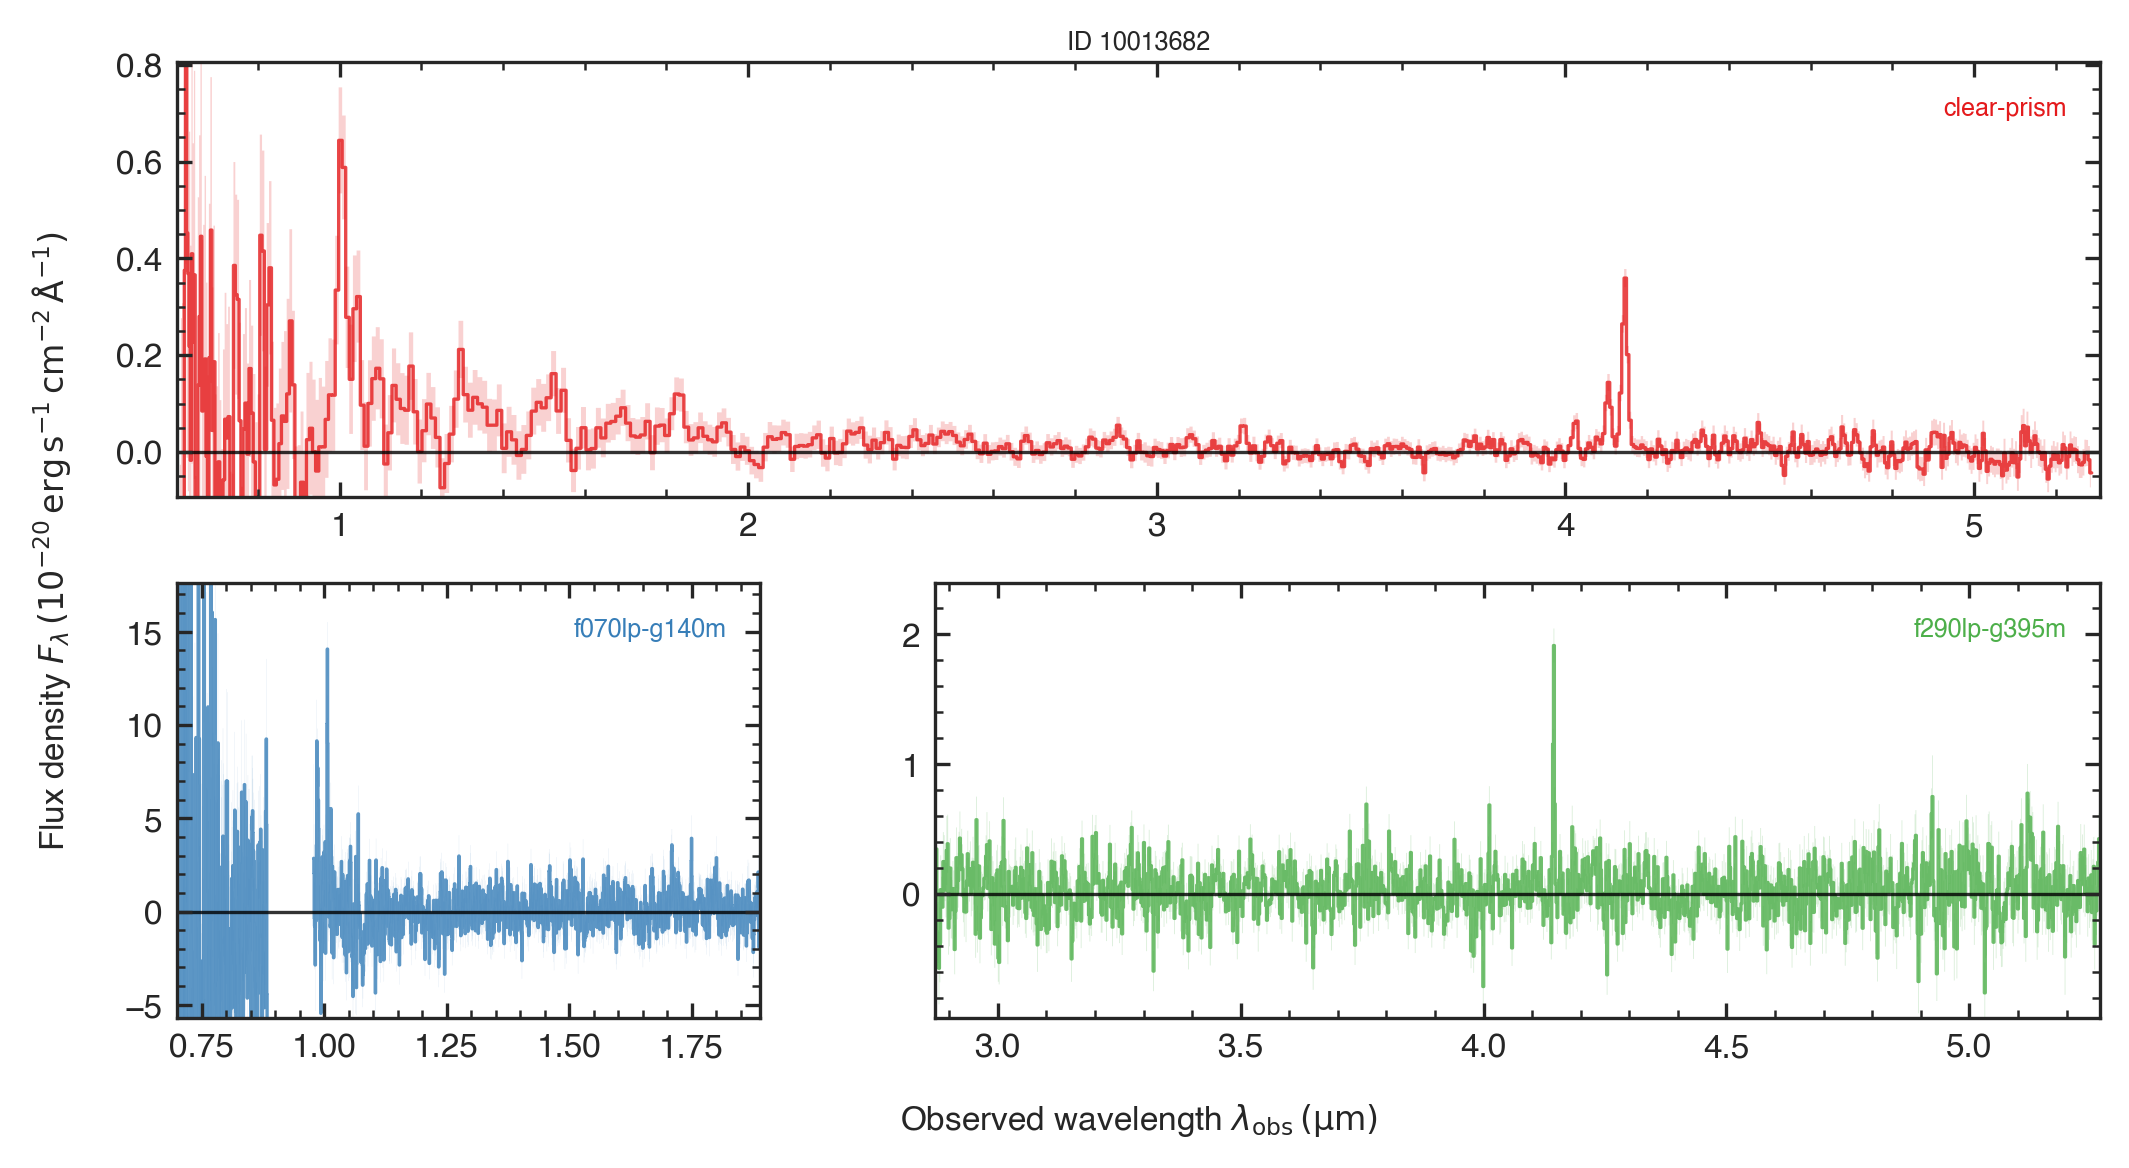

In [12]:
# Repeat the exercise for ID 10013682 in GOODS-S
field = "goods-s"
tier = "deephst"
ID = 10013682

wl_obs_dict = {}
flux_dict = {}
flux_err_dict = {}

for fg in filter_gratings:
    print("Downloading {} spectrum of ID {} in {}...".format(fg, ID, field))
    obs_id = "hlsp_jades_jwst_nirspec_{}-{}-{:08d}_{}_v1.0".format(field, tier, ID, fg)
    download_data(obs_id)
    print("Done!")

    print("Reading in {} spectrum of ID {} in {}...".format(fg, ID, field), end=' ')
    with fits.open("../data/mastDownload/HLSP/{obs_id}/{obs_id}_x1d.fits".format(obs_id=obs_id)) as hdulist_1D:
        wl_obs_dict[fg] = hdulist_1D["EXTRACT1D"].data["WAVELENGTH"] # in μm
        flux_dict[fg] = hdulist_1D["EXTRACT1D"].data["FLUX"] # in erg/s/cm^2/Å
        flux_err_dict[fg] = hdulist_1D["EXTRACT1D"].data["FLUX_ERR"] # in erg/s/cm^2/Å
    print("Done!")

fig = plot_spectra(ID, wl_obs_dict, flux_dict, flux_err_dict, savefig=True)[0]
plt.show()
plt.close(fig)

Set up the model to measure the redshift of ID 1899 with the rest-frame optical lines.

Redshift guess: 7.250
Expected precision: 0.00497


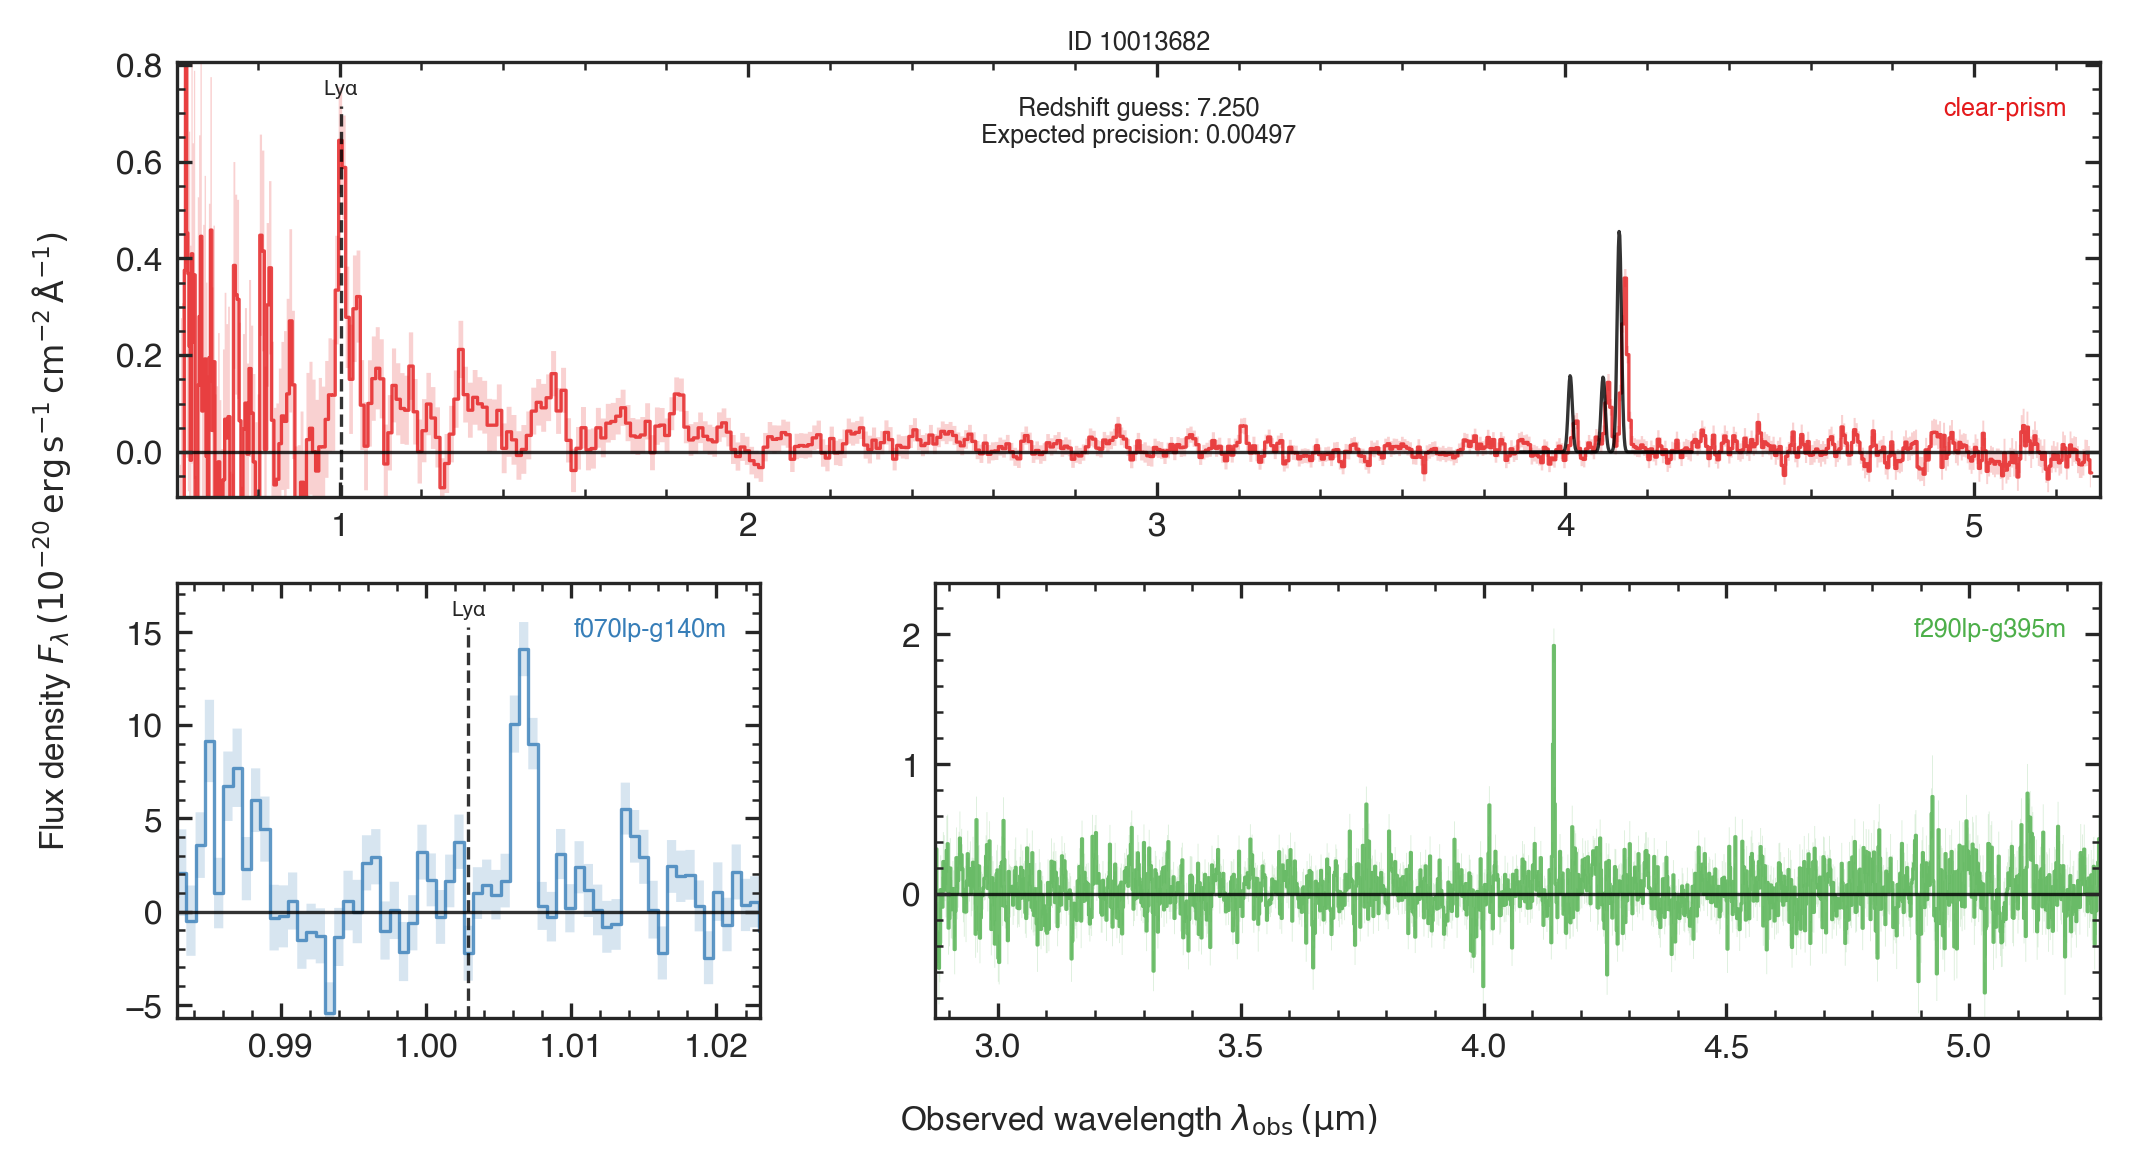

In [13]:
# Verify the currently loaded data is still for ID 10013682
assert ID == 10013682

# Set up parameters, starting with redshift (z), continuum level (cont), and line width in velocity space (sigma_v)
params = lmfit.Parameters()

z_guess = 7.25
z_min = 7.23
z_max = 7.28

#                NAME           VALUE           VARY        MIN     MAX         EXPR        BRUTE_STEP
params.add_many(('z',           z_guess,        True,       z_min,  z_max,      None,       None),
                ("cont",        0.0,            True,       0,      10,         None,       None),
                ("sigma_v",     100.0,          True,       0,      500,        None,       None))

# Given the lower SNR in the G395M spectrum, this time we will fit to the
# lower-resolution PRISM data – again select finite subset to fit to
wl_select = (wl_obs_dict["clear-prism"] > 3.9) * (wl_obs_dict["clear-prism"] < 4.3)
x_fit = wl_obs_dict["clear-prism"][wl_select] * lconv # from μm to Å
y_fit = flux_dict["clear-prism"][wl_select] * conv # in 1e-21 erg/s/cm^2/Å
y_fit_err = flux_err_dict["clear-prism"][wl_select] * conv # in 1e-21 erg/s/cm^2/Å

# Assume a constant spectral resolution of R = 350
spectral_resolution = 350.0

# Dictionary containing rest-frame wavelengths of lines to be fit
line_dict = {"Hbeta": 4862.71, "OIII4960": 4960.295, "OIII5008": 5008.24}

# For each line, add amplitude parameter
for line in line_dict:
    expr = "amplitude_OIII4960 * 2.98" if line == "OIII5008" else None
    params.add("amplitude_{}".format(line), value=20, vary=True, min=0, max=1e4, expr=expr)

# Plot an example model
fig, axes = plot_spectra(ID, wl_obs_dict, flux_dict, flux_err_dict, redshift=z_guess)

text = "Redshift guess: {:.3f}".format(z_guess)
text += "\nExpected precision: {:.5f}".format(line_dict["OIII4960"]/1e4*(1.0+z_guess)/spectral_resolution/FWHM_to_sigma)
print(text)
axes["clear-prism"].annotate(text=text, xy=(0.5, 1), xytext=(0, -8),
                             xycoords="axes fraction", textcoords="offset points", va="top", ha="center")
x_model, y_model = emission_line_model(params.copy(), x=x_fit, line_dict=line_dict, spectral_resolution=spectral_resolution)
axes["clear-prism"].plot(x_model/lconv, y_model, color='k', alpha=0.8)

plt.show()
plt.close(fig)

Next, fit the model.

In [14]:
# Verify the currently loaded data is still for ID 10013682
assert ID == 10013682

# Fit the model to the data
fit_result = lmfit.minimize(emission_line_model, params, method="leastsq",
                            args=(x_fit,), kws=dict(data=y_fit, data_err=y_fit_err,
                            line_dict=line_dict, spectral_resolution=spectral_resolution))
print(fit_result.message)
fit_result.params.pretty_print()
print(lmfit.fit_report(fit_result))

Fit succeeded.
Name                   Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude_Hbeta        10.18        0    1e+04     1.67     True     None     None
amplitude_OIII4960      20.7        0    1e+04   0.7064     True     None     None
amplitude_OIII5008      61.7        0    1e+04    2.105    False amplitude_OIII4960 * 2.98     None
cont                0.002387        0       10 0.001874     True     None     None
sigma_v                321.8        0      500    28.57     True     None     None
z                      7.277     7.23     7.28 0.0004972     True     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 62
    # data points      = 67
    # variables        = 5
    chi-square         = 38.6421872
    reduced chi-square = 0.62326108
    Akaike info crit   = -26.8733165
    Bayesian info crit = -15.8498534
[[Variables]]
    z:                   7.27664657 +/- 4.9723e-04 (0.01%) (init = 7.25)
    cont:       

Having performed the fitting procedure, plot the results.

Measured redshift: 7.276647 ± 0.000497


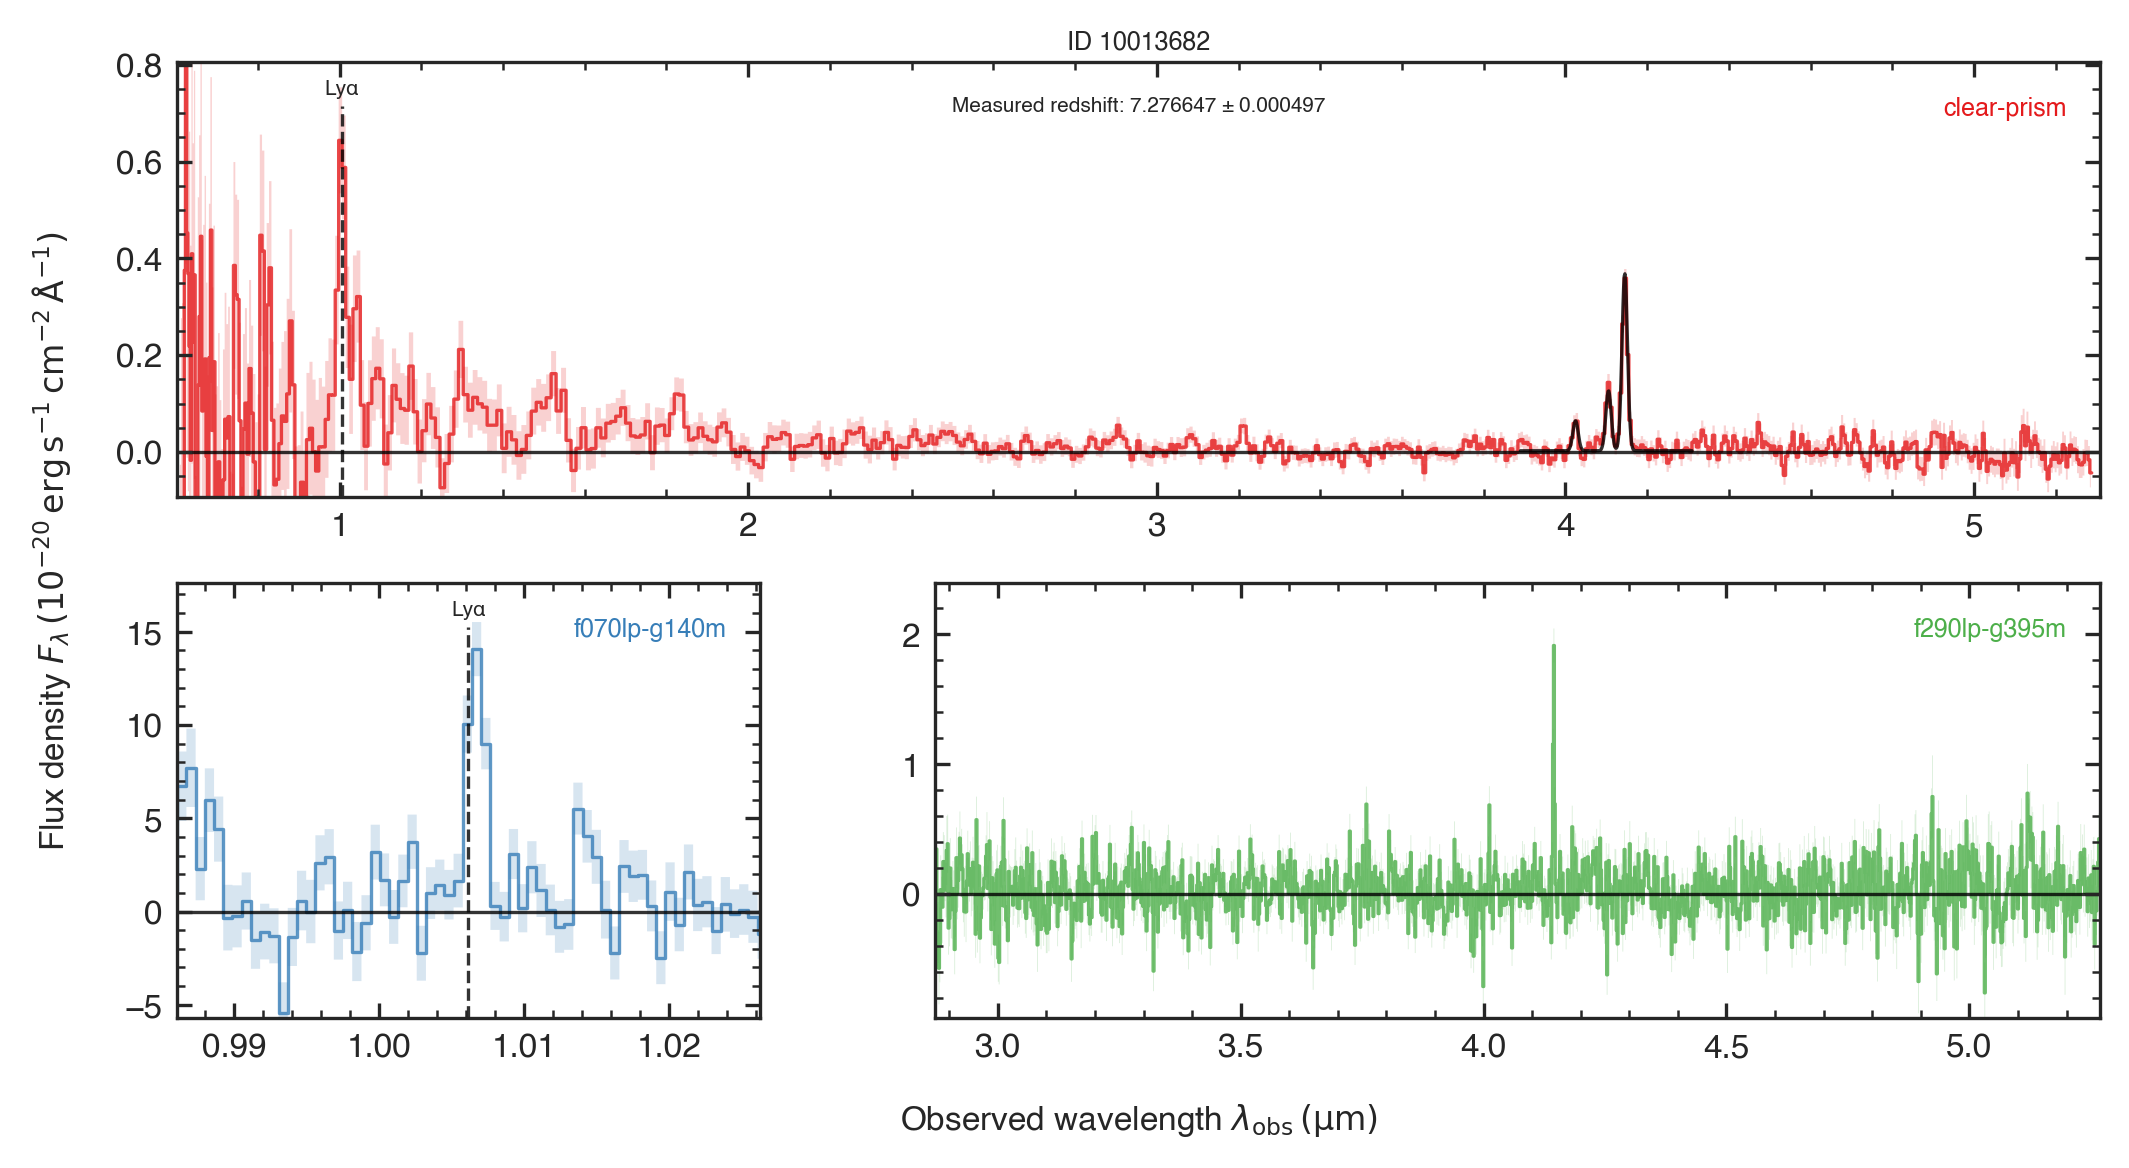

In [15]:
# Verify the currently loaded data is still for ID 10013682
assert ID == 10013682

# Read in the best-fit redshift and its uncertainty
fit_values = fit_result.params.valuesdict()
z_fit = fit_values['z']
z_fit_err = fit_result.params.get('z').stderr
F_Hbeta_fit = fit_values["amplitude_Hbeta"]
F_Hbeta_fit_err = fit_result.params.get("amplitude_Hbeta").stderr

# Show the best-fit high-resolution model curve
fig, axes = plot_spectra(ID, wl_obs_dict, flux_dict, flux_err_dict, redshift=z_fit)

text = "Measured redshift: {:.{prec}f} ± {:.{prec}f}".format(z_fit, z_fit_err, prec=max(0, 2-math.floor(np.log10(z_fit_err))))
print(text)
axes["clear-prism"].annotate(text=text, xy=(0.5, 1), xytext=(0, -8), xycoords="axes fraction", textcoords="offset points",
                                va="top", ha="center", size="small")

x_model, y_model = emission_line_model(fit_values, x=x_fit, line_dict=line_dict, spectral_resolution=spectral_resolution)
axes["clear-prism"].plot(x_model/lconv, y_model, color='k', alpha=0.8)

plt.show()
plt.close(fig)

With a measured redshift, measure the flux of the Lyα line.

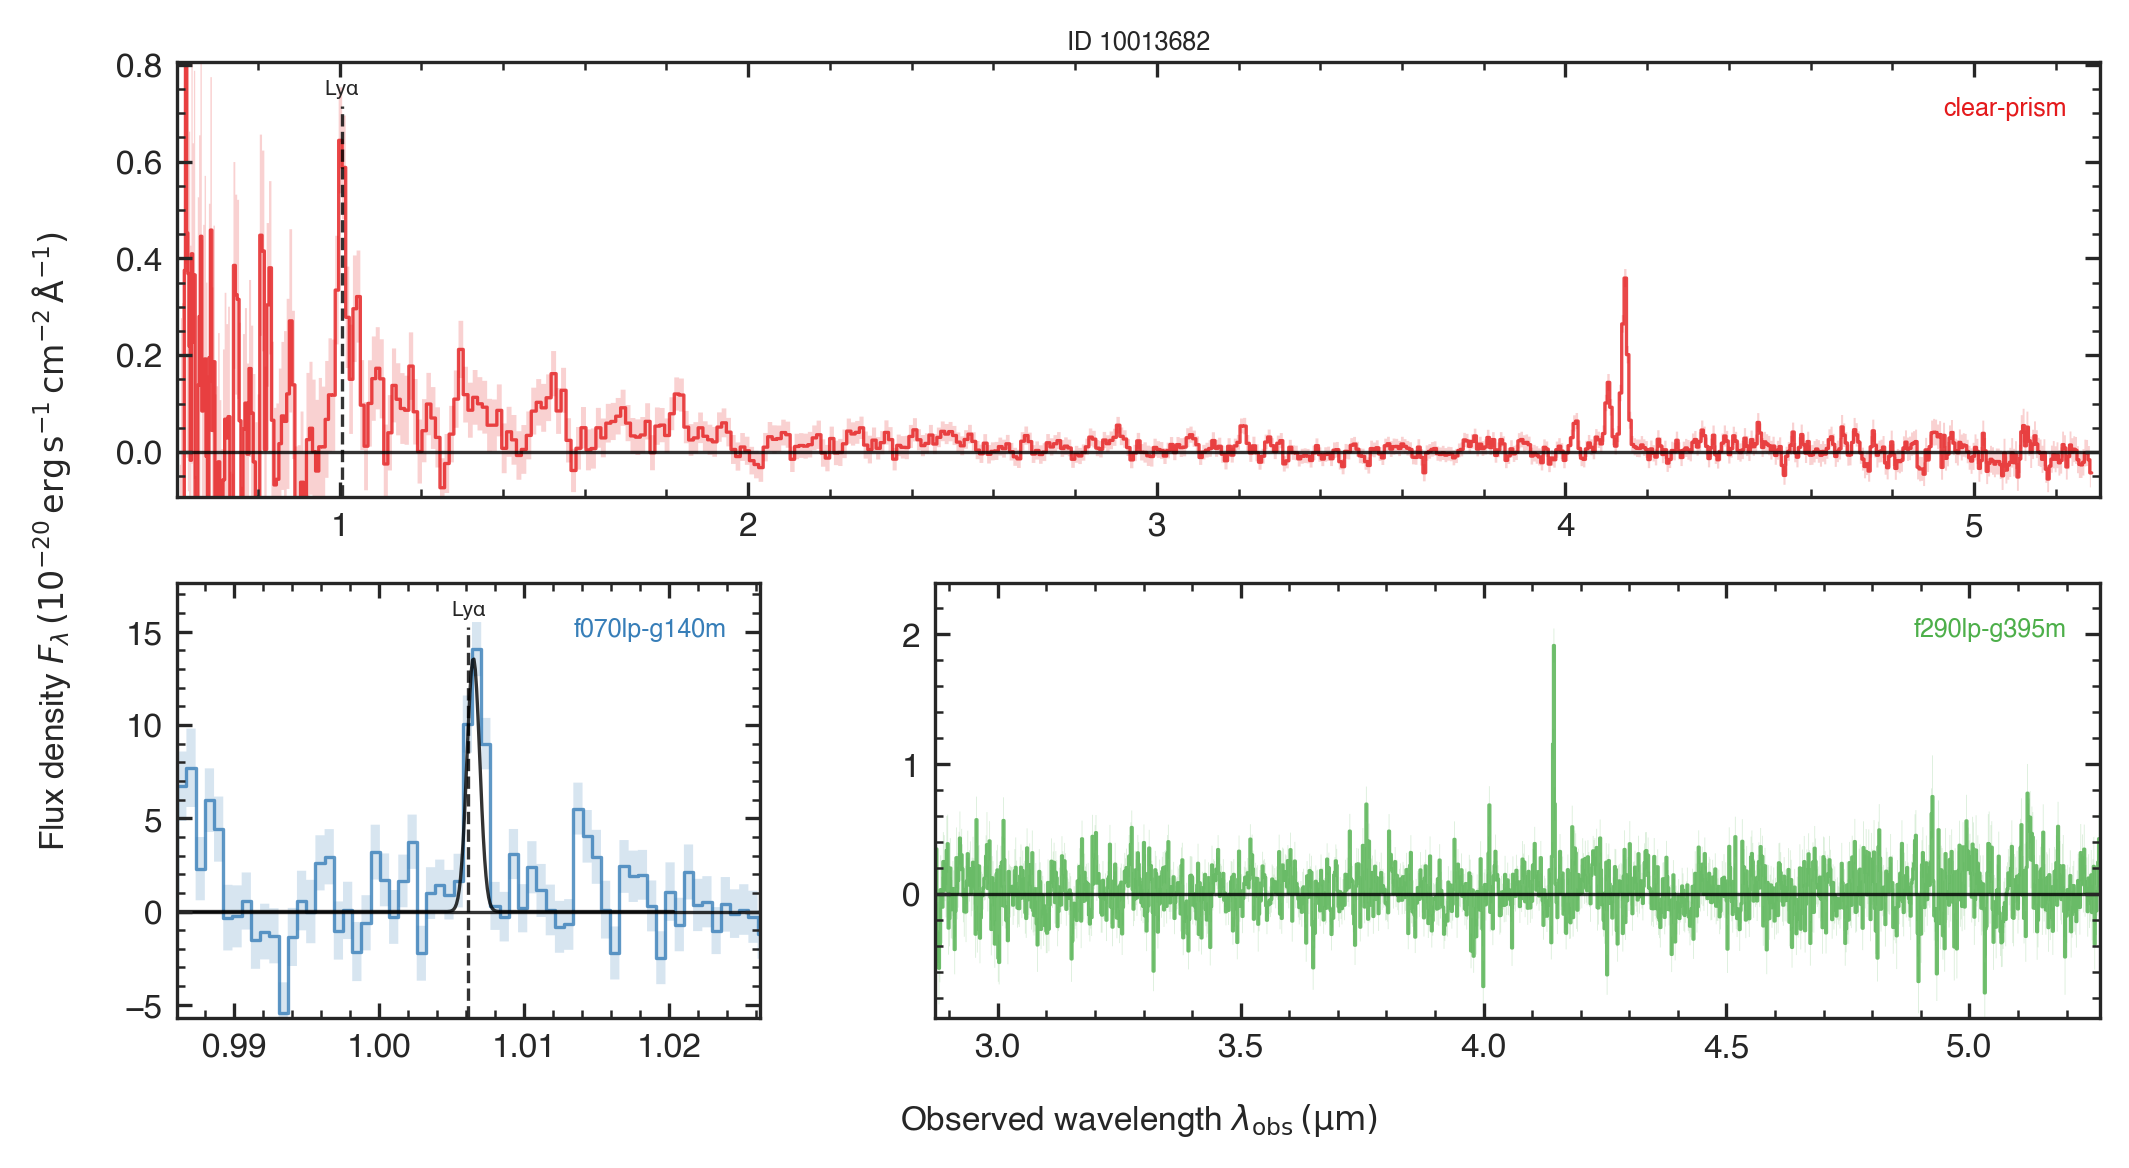

In [16]:
# Verify the currently loaded data is still for ID 10013682
assert ID == 10013682

# Set up parameters, starting with redshift (z), continuum level (cont), and line width in velocity space (sigma_v)
params = lmfit.Parameters()

#                NAME           VALUE           VARY        MIN     MAX         EXPR        BRUTE_STEP
params.add_many(('z',           z_fit,          False,      None,   None,       None,       None),
                ("cont",        0.0,            False,      None,   None,       None,       None),
                ("sigma_v",     100.0,          True,       0,      500,        None,       None))

# Given the lower SNR in the G395M spectrum, this time we will fit to the
# lower-resolution PRISM data – again select finite subset to fit to
wl_select = (wl_obs_dict["f070lp-g140m"] > 0.98) * (wl_obs_dict["f070lp-g140m"] < 1.02)
x_fit = wl_obs_dict["f070lp-g140m"][wl_select] * lconv # from μm to Å
y_fit = flux_dict["f070lp-g140m"][wl_select] * conv # in 1e-21 erg/s/cm^2/Å
y_fit_err = flux_err_dict["f070lp-g140m"][wl_select] * conv # in 1e-21 erg/s/cm^2/Å

# Assume a constant spectral resolution of R = 1500
spectral_resolution = 1500.0

# Dictionary containing rest-frame wavelengths of lines to be fit
line_dict = {"Lya": wl_Lya}

# Add amplitude parameter and velocity offset
for line in line_dict:
    params.add("amplitude_{}".format(line), value=150, vary=True, min=0, max=1e4)
    params.add("deltav_{}".format(line), value=100, vary=True, min=0, max=300)

# Plot an example model
fig, axes = plot_spectra(ID, wl_obs_dict, flux_dict, flux_err_dict, redshift=z_fit)

x_model, y_model = emission_line_model(params.copy(), x=x_fit, line_dict=line_dict, spectral_resolution=spectral_resolution)
axes["f070lp-g140m"].plot(x_model/lconv, y_model, color='k', alpha=0.8)

plt.show()
plt.close(fig)

Next, fit the model.

In [17]:
# Verify the currently loaded data is still for ID 10013682
assert ID == 10013682

# Fit the model to the data
fit_result = lmfit.minimize(emission_line_model, params, method="leastsq",
                            args=(x_fit,), kws=dict(data=y_fit, data_err=y_fit_err,
                            line_dict=line_dict, spectral_resolution=spectral_resolution))
print(fit_result.message)
fit_result.params.pretty_print()
print(lmfit.fit_report(fit_result))

Fit succeeded.
Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude_Lya     230.9        0    1e+04     34.4     True     None     None
cont                  0     -inf      inf        0    False     None     None
deltav_Lya        152.3        0      300    32.27     True     None     None
sigma_v           155.5        0      500    37.12     True     None     None
z                 7.277     -inf      inf        0    False     None     None
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 63
    # variables        = 3
    chi-square         = 164.984845
    reduced chi-square = 2.74974741
    Akaike info crit   = 66.6512903
    Bayesian info crit = 73.0806944
[[Variables]]
    z:              7.276647 (fixed)
    cont:           0 (fixed)
    sigma_v:        155.455744 +/- 37.1169498 (23.88%) (init = 100)
    amplitude_Lya:  230.856627 +/- 34.4039808 (14.90%) (init = 150)
    deltav_Lya:    

Having performed the fitting procedure, plot the results.

Lyα measurements
Flux: 230.9 ± 34.4 x 10^-20 erg/s/cm^2
Δv: 152.3 ± 32.3 km/s
Flux ratio with Hβ: 22.69 ± 5.03
Escape fraction: 0.97 ± 0.22


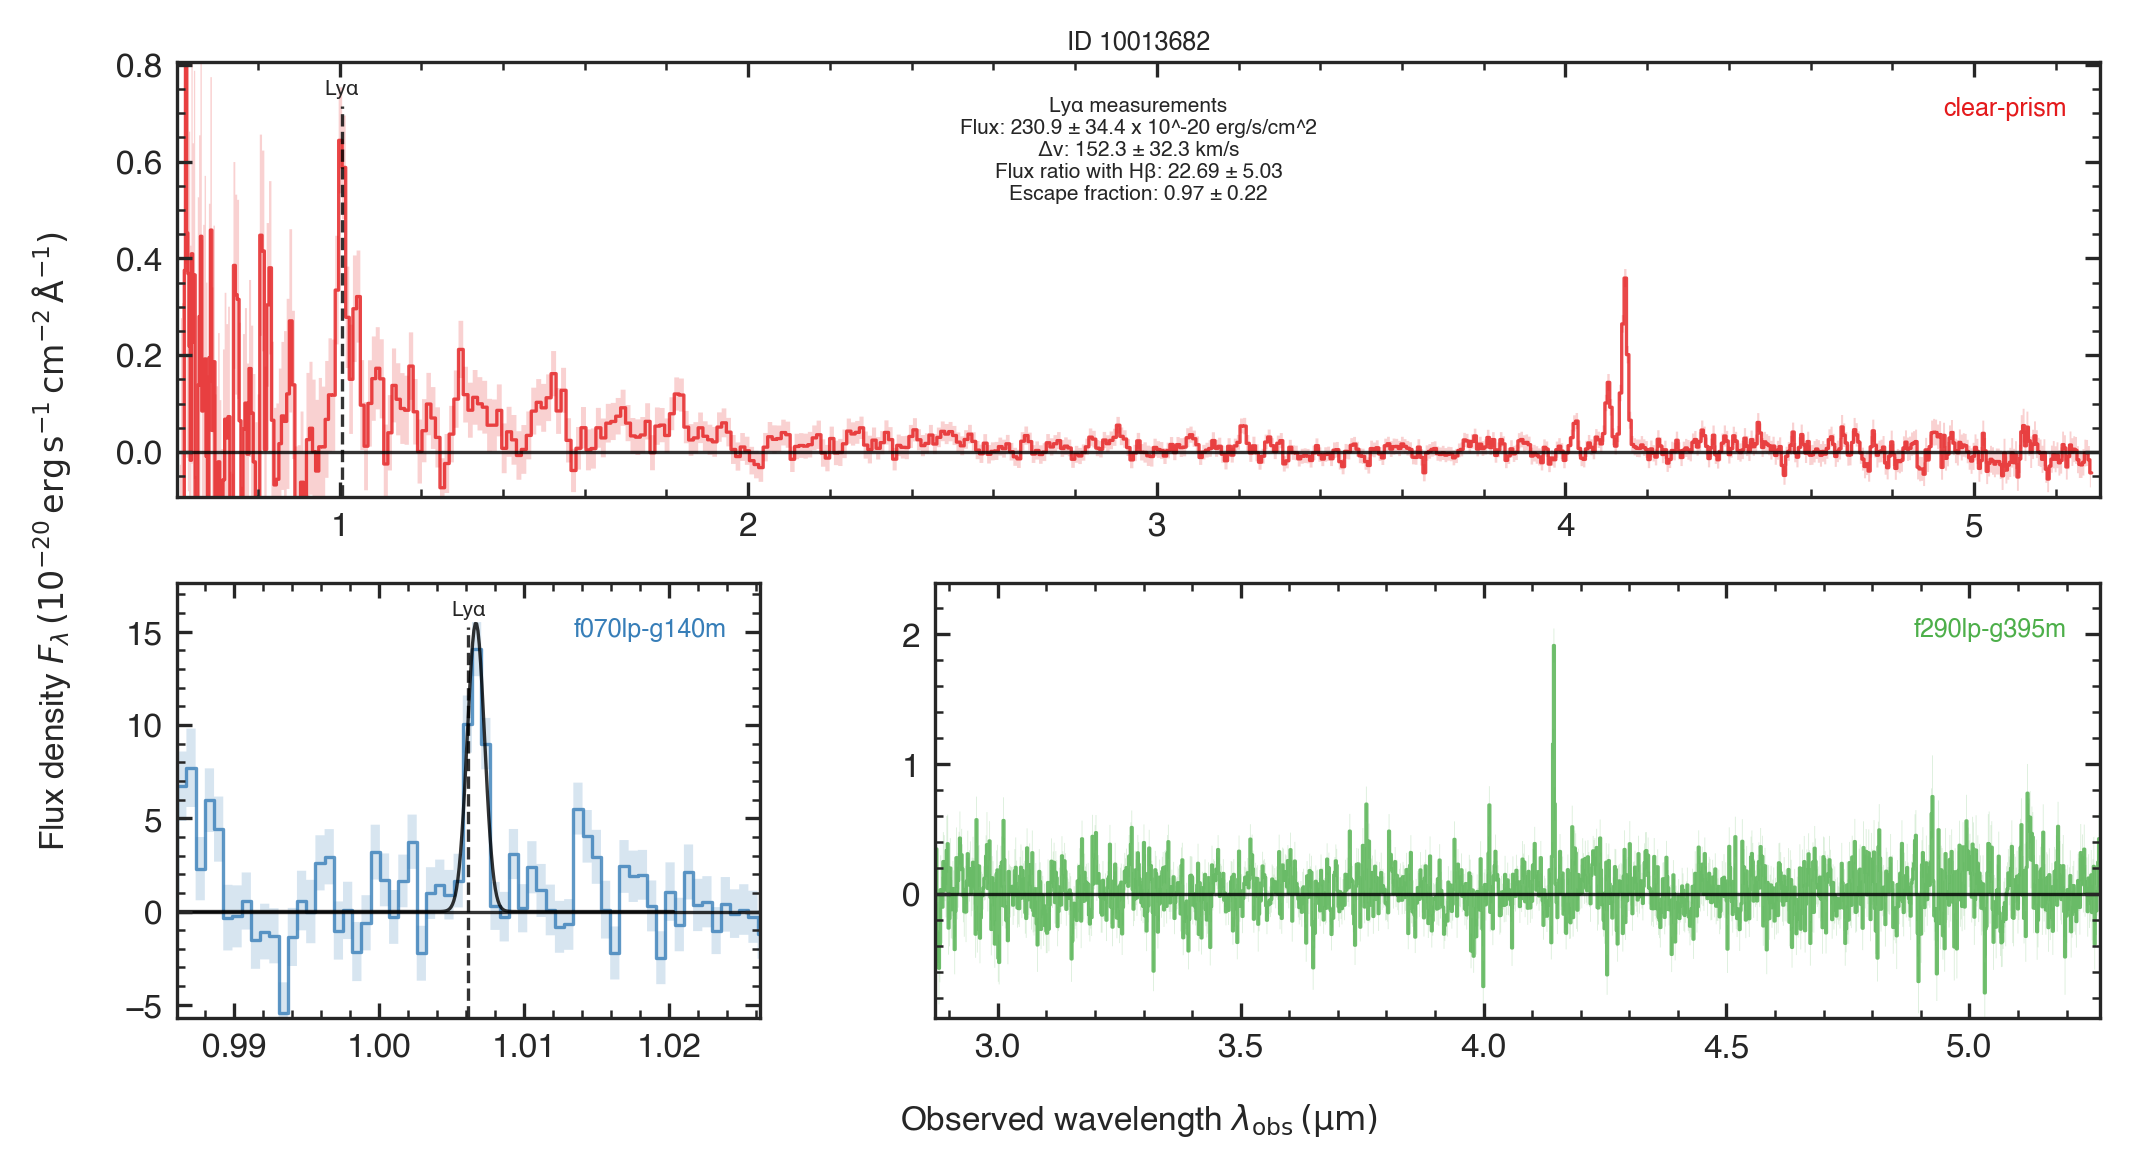

In [18]:
# Verify the currently loaded data is still for ID 10013682
assert ID == 10013682

# Read in the best-fit redshift and its uncertainty
fit_values = fit_result.params.valuesdict()
F_Lya_fit = fit_values["amplitude_Lya"]
F_Lya_fit_err = fit_result.params.get("amplitude_Lya").stderr
deltav_Lya_fit = fit_values["deltav_Lya"]
deltav_Lya_fit_err = fit_result.params.get("deltav_Lya").stderr

Lya_Hbeta_ratio = F_Lya_fit / F_Hbeta_fit
Lya_Hbeta_ratio_err = Lya_Hbeta_ratio * np.sqrt((F_Lya_fit_err/F_Lya_fit)**2 + (F_Hbeta_fit_err/F_Hbeta_fit)**2)
f_esc_Lya = Lya_Hbeta_ratio / 23.3
f_esc_Lya_err = Lya_Hbeta_ratio_err / 23.3

# Show the best-fit high-resolution model curve
fig, axes = plot_spectra(ID, wl_obs_dict, flux_dict, flux_err_dict, redshift=z_fit)

text = "Lyα measurements"
text += "\nFlux: {:.{prec}f} ± {:.{prec}f} x 10^-20 erg/s/cm^2".format(F_Lya_fit, F_Lya_fit_err, prec=max(0, 2-math.floor(np.log10(F_Lya_fit_err))))
text += "\nΔv: {:.{prec}f} ± {:.{prec}f} km/s".format(deltav_Lya_fit, deltav_Lya_fit_err, prec=max(0, 2-math.floor(np.log10(deltav_Lya_fit_err))))
text += "\nFlux ratio with Hβ: {:.2f} ± {:.2f}".format(Lya_Hbeta_ratio, Lya_Hbeta_ratio_err)
text += "\nEscape fraction: {:.2f} ± {:.2f}".format(f_esc_Lya, f_esc_Lya_err)
print(text)
axes["clear-prism"].annotate(text=text, xy=(0.5, 1), xytext=(0, -8), xycoords="axes fraction", textcoords="offset points",
                                va="top", ha="center", size="small")

x_model, y_model = emission_line_model(fit_values, x=x_fit, line_dict=line_dict, spectral_resolution=spectral_resolution)
axes["f070lp-g140m"].plot(x_model/lconv, y_model, color='k', alpha=0.8)

plt.show()
plt.close(fig)